# Q学習とSARSA法でCartPoleを学習する

In [1]:
# ref: http://neuro-educator.com/rl1/
# ref: https://qiita.com/sugulu/items/7a14117bbd3d926eb1f2

In [2]:
import gym
import numpy as np
import pandas as pd
from collections import deque 

import utils.display as disp
import utils.learning as learn

In [3]:
class QLearning:
    def __init__(self, num_state, num_action, alpha=0.2, gamma=0.99):
        self.q_table = np.zeros(shape=(num_state, num_action))
        #self.q_table = np.random.uniform(low=-1, high=1, size=(num_state, num_action))
        self.alpha = alpha # 学習率
        self.gamma = gamma# 時間割引率
    
    def get_action(self, state, episode):
         # ε-グリーディ法で行動を選択
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice([0, 1])
        return action
    
    # Q学習
    # Q値が最も高い次の行動で　Q値を更新する
    def update_q_table(self, action, state, next_state, reward):
        # 行動後の最大Q値
        next_max_q_value = max(self.q_table[next_state])
        # 行動前の最大Q値
        q_value = self.q_table[state][action]
        # Q値を更新
        self.q_table[state][action]= (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * next_max_q_value)
        
    # SARSA法
    # 実際に実行した次のアクションで　Q値を更新する
    def update_q_table_sarsa(self, action, next_action, state, next_state, reward):
        # 行動後の最大Q値
        next_max_q_value = self.q_table[next_state][next_action]
        # 行動前の最大Q値
        q_value = self.q_table[state][action]
        # Q値を更新
        self.q_table[state][action]= (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * next_max_q_value)

In [4]:
env = gym.make('CartPole-v0')
observation = env.reset()

observation_low = [-2.4, -3.0, -0.5, -2.0]
#observation_low = env.observation_space.low
observation_hight = [2.4, 3.0, 0.5, 2.0]
#observation_hight = env.observation_space.hight

num_max_episode = 5000 # 学習に使用するエピソード回数
num_max_step = 200 # 1エピソードのステップ数
num_action = 2 # アクション数
num_dizitized = 10 # observationを離散値にする際の分割数
num_state = num_dizitized ** observation.shape[0]
num_goal_avg_episode = 10 # 学習を終了させる平均計算をするエピソード数
goal_avg_rewaed = 195 # 学習を終了させる平均報酬

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Q学習で訓練

In [5]:
learning = QLearning(num_state, num_action)
observation = env.reset()

rewards = []
rewards_goal_eval = np.zeros(num_goal_avg_episode)

for episode in range(num_max_episode):
    total_reward = 0
    observation = env.reset()
    
    for step in range(num_max_step):
        state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
        action = learning.get_action(state, episode)
        next_observation, reward, done, info =  env.step(action)
        if done:
            if step < num_max_step-5:
                reward = -200
            else:
                reward = 1
        next_state = learn.digitize_state(next_observation, observation_low, observation_hight, num_dizitized)
        learning.update_q_table(action, state, next_state, reward)
        total_reward += reward
        observation = next_observation
        if done:
            rewards.append(total_reward)
            rewards_goal_eval = np.hstack((rewards_goal_eval[1:], total_reward))
            break
            
    # ゴール達成のため学習終了
    reward_avg = rewards_goal_eval.mean()
    if episode % 100 == 0:
        print('episode: {}, episode_reward: {}'.format(episode, reward_avg))
    if reward_avg >= goal_avg_rewaed:
        print('learning finished: {}'.format(episode))
        break

episode: 0, episode_reward: -18.8
episode: 100, episode_reward: -118.5
episode: 200, episode_reward: -98.4
episode: 300, episode_reward: -100.6
episode: 400, episode_reward: -101.2
episode: 500, episode_reward: -101.6
episode: 600, episode_reward: -108.3
episode: 700, episode_reward: -105.1
episode: 800, episode_reward: -92.6
episode: 900, episode_reward: -87.0
episode: 1000, episode_reward: -92.3
episode: 1100, episode_reward: -92.4
episode: 1200, episode_reward: -97.0
episode: 1300, episode_reward: -94.4
episode: 1400, episode_reward: -101.1
episode: 1500, episode_reward: -91.1
episode: 1600, episode_reward: -84.2
episode: 1700, episode_reward: -80.1
episode: 1800, episode_reward: -86.2
episode: 1900, episode_reward: -96.4
episode: 2000, episode_reward: -91.5
episode: 2100, episode_reward: -82.5
episode: 2200, episode_reward: -129.8
episode: 2300, episode_reward: -77.6
episode: 2400, episode_reward: 152.6
episode: 2500, episode_reward: 128.9
episode: 2600, episode_reward: 148.4
learn

### 学習後のQ値でシュミレーション


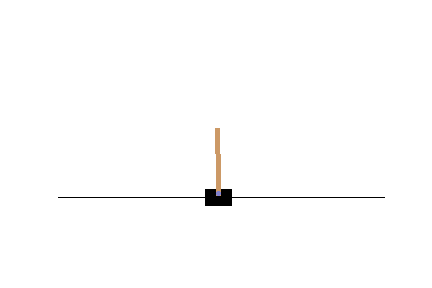
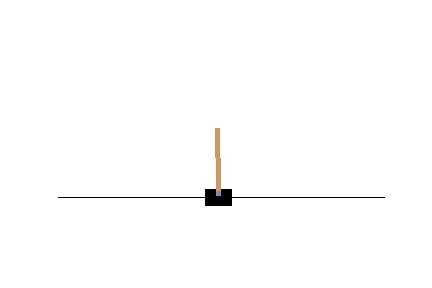
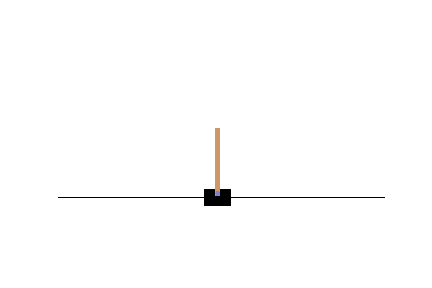
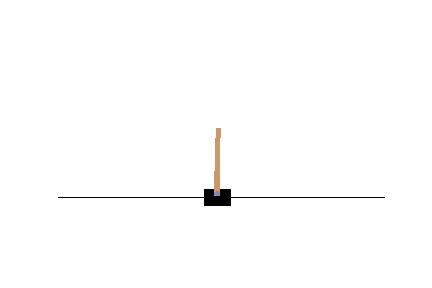
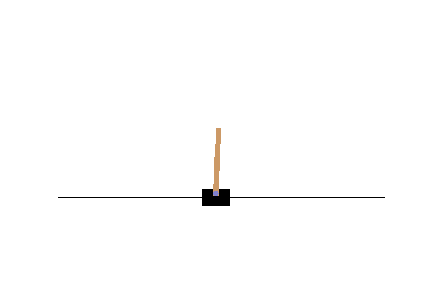
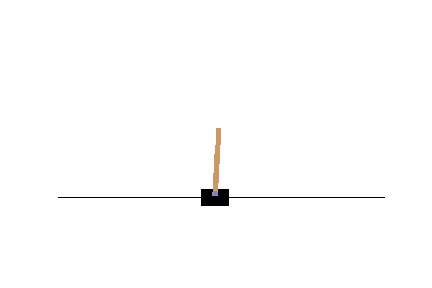
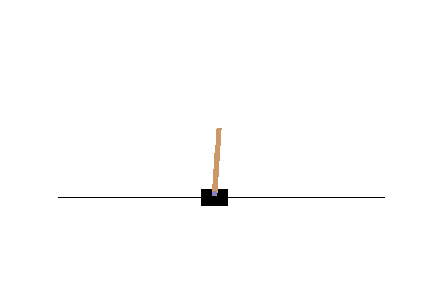
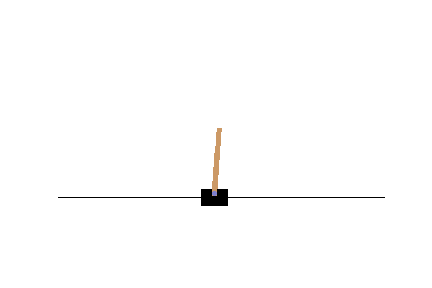
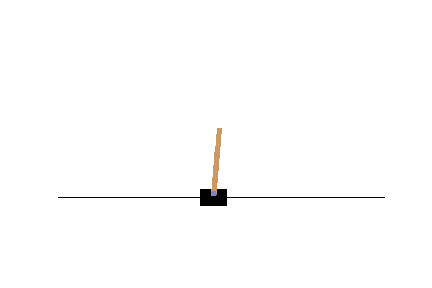
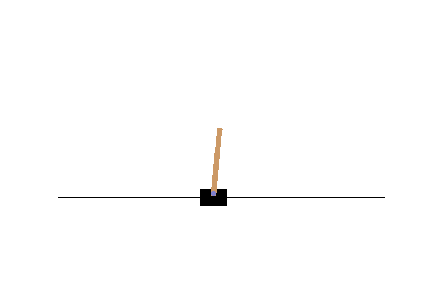
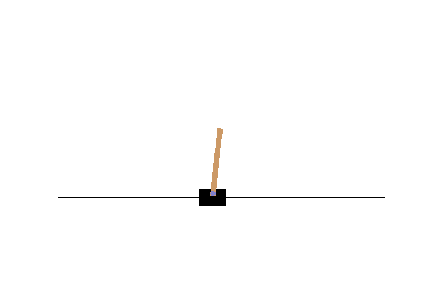
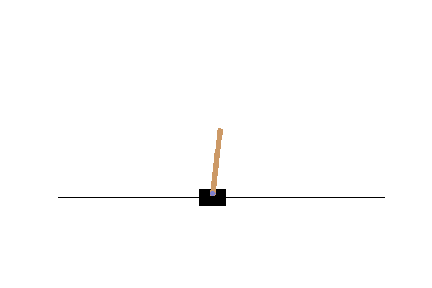
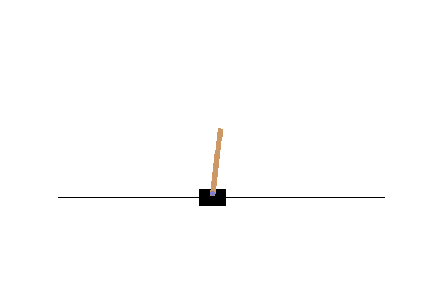
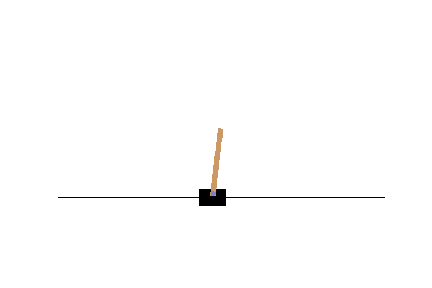
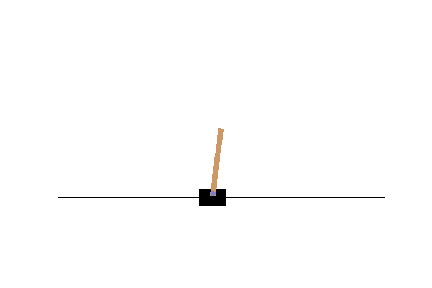
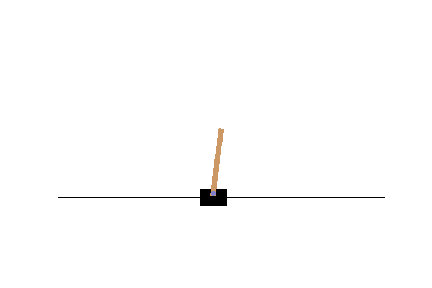
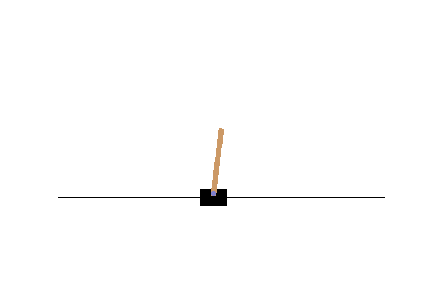
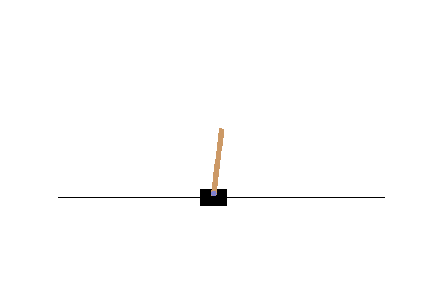
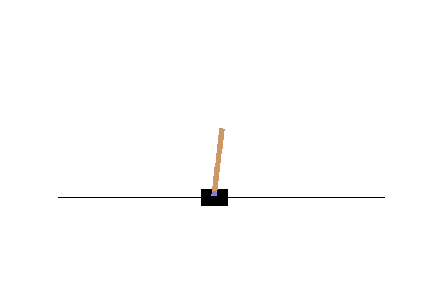
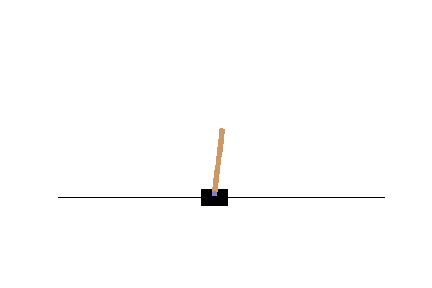
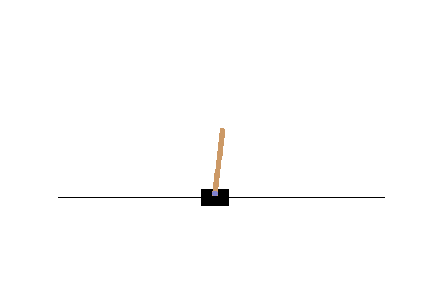
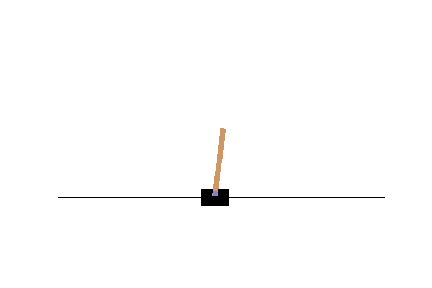
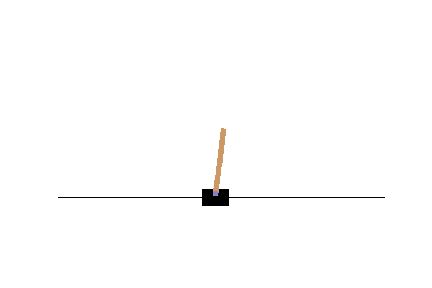
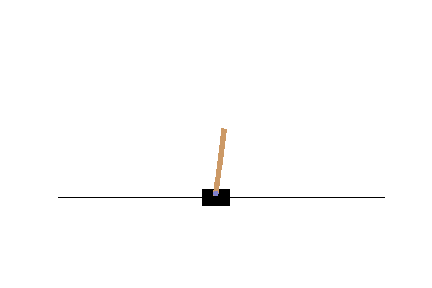
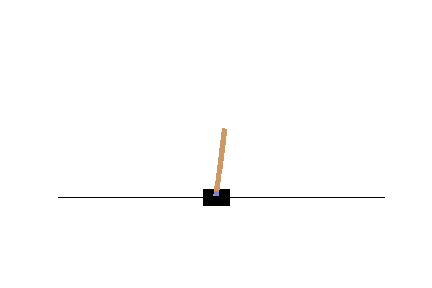
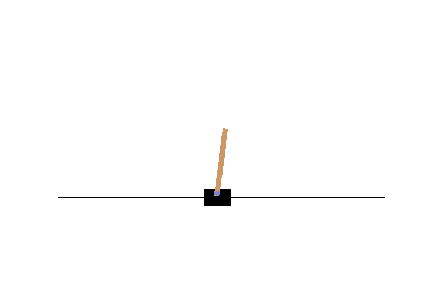
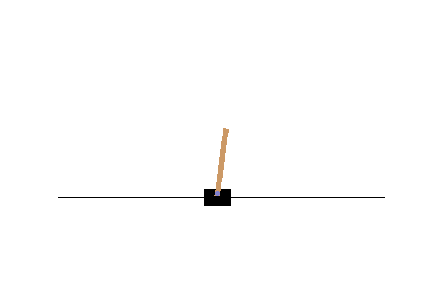
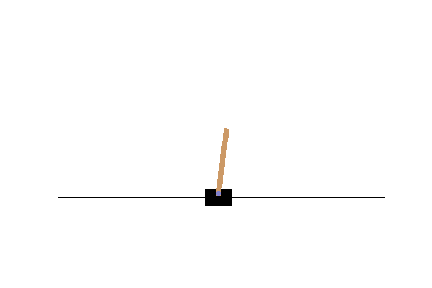
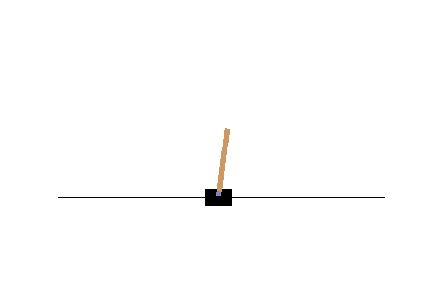
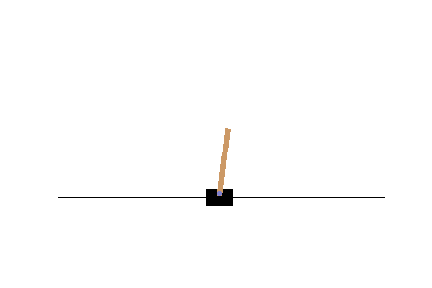
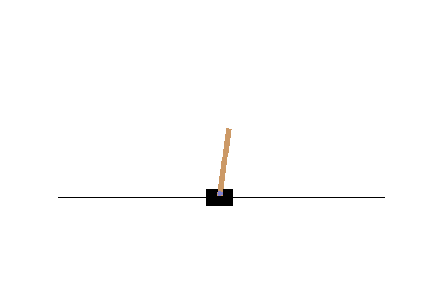
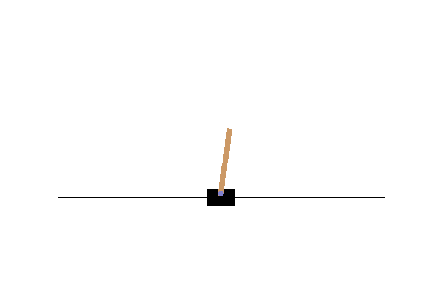
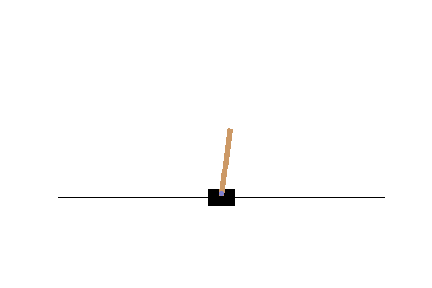
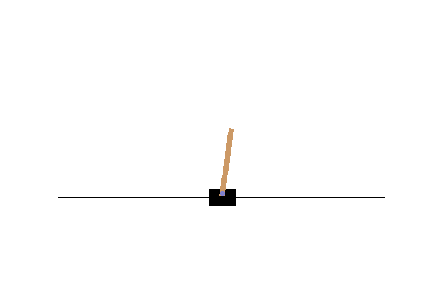
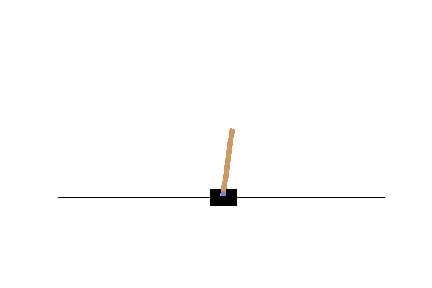
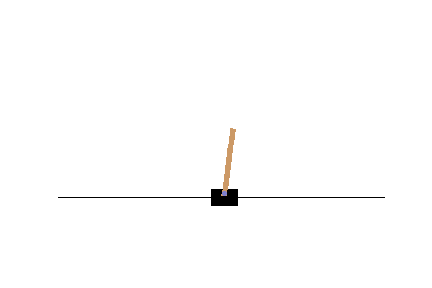
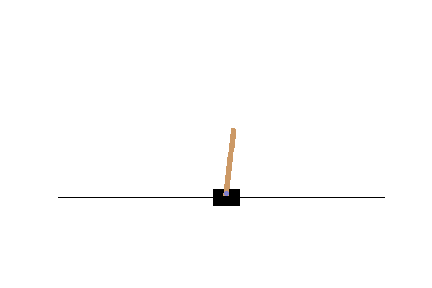
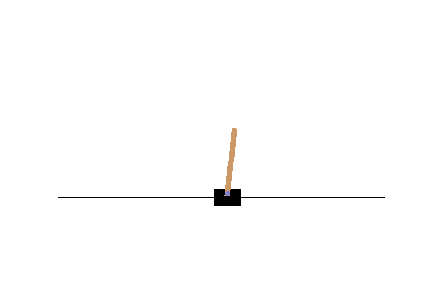
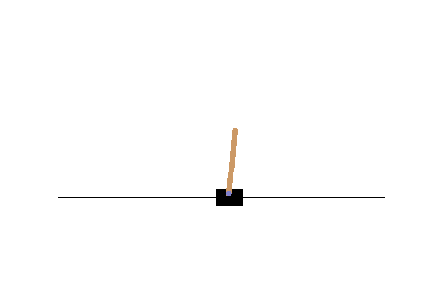
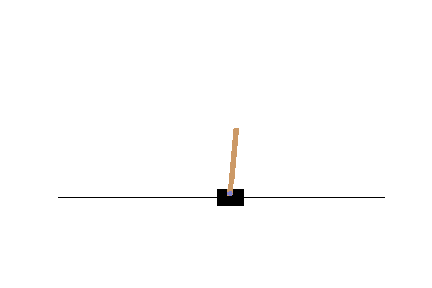
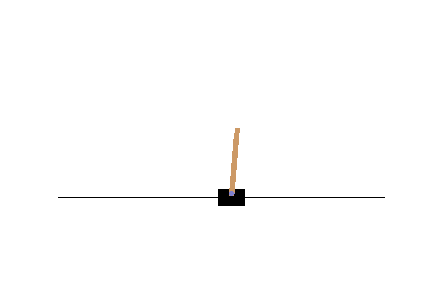
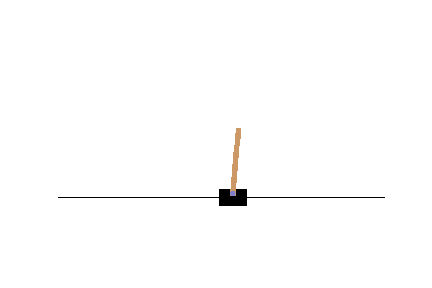
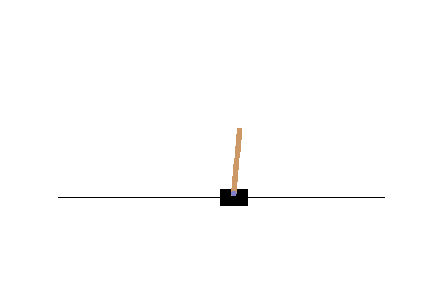
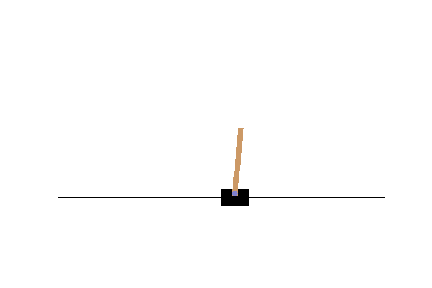
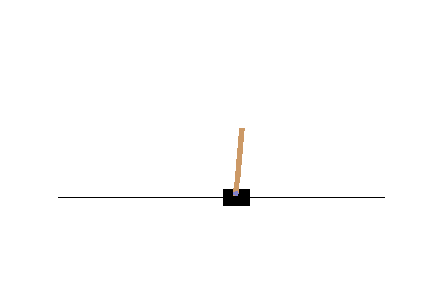
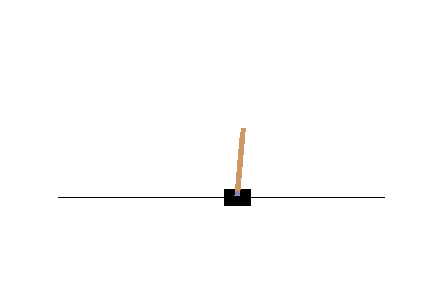
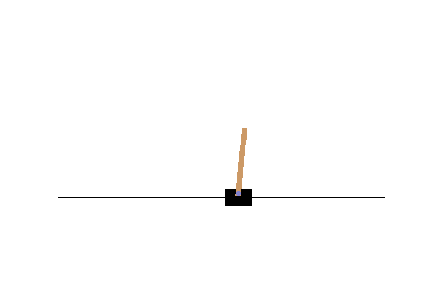
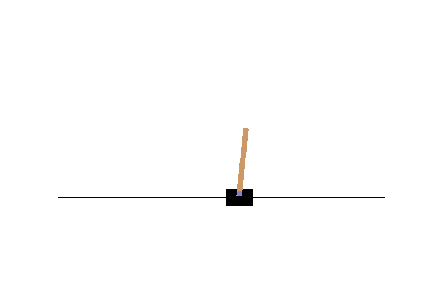
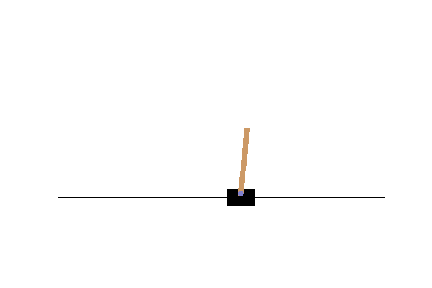
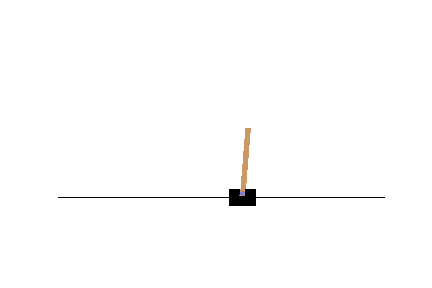
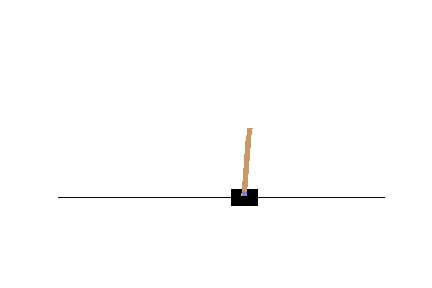
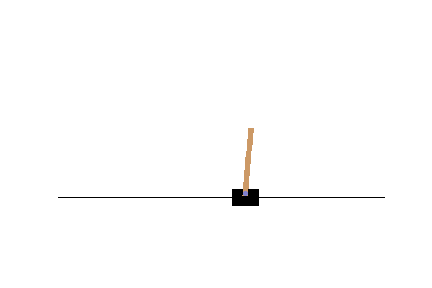
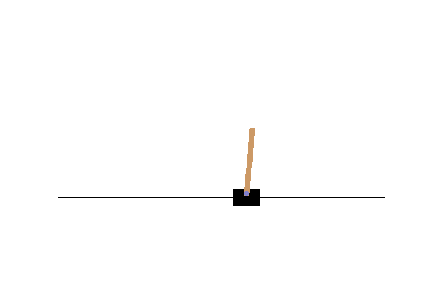
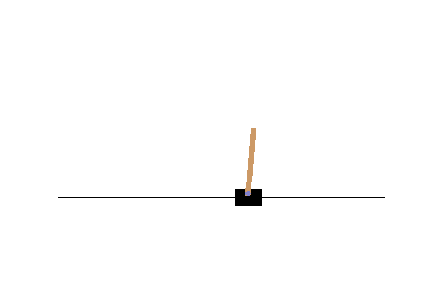
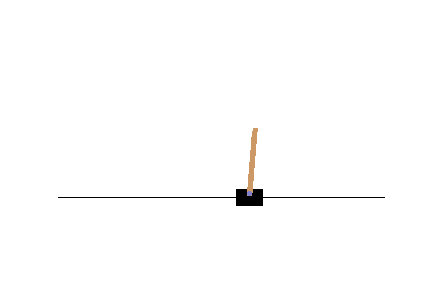
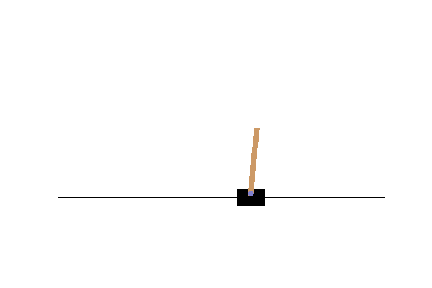
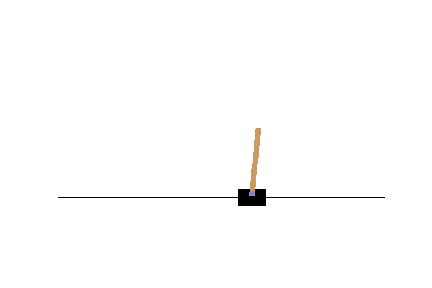
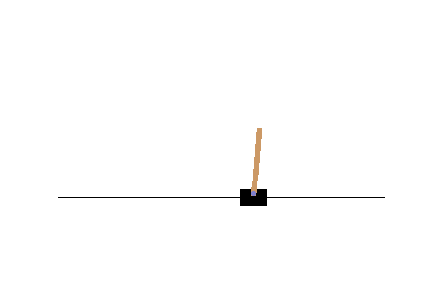
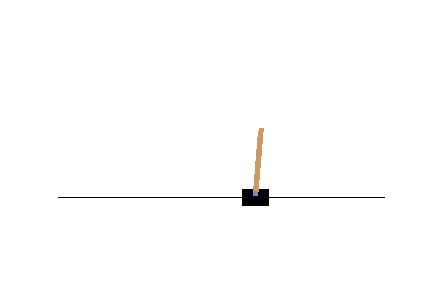
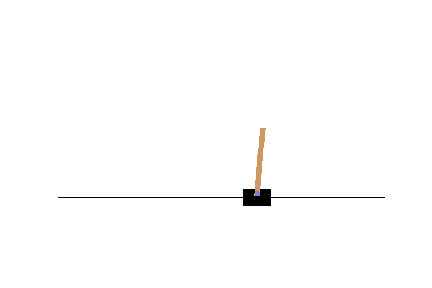
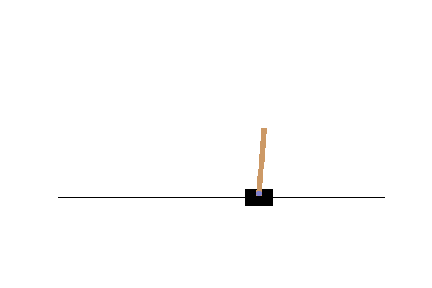
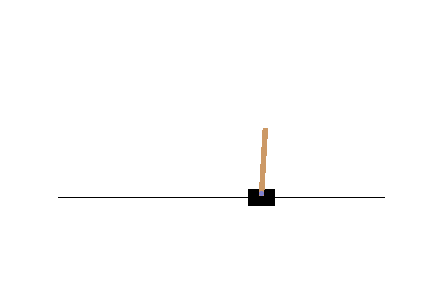
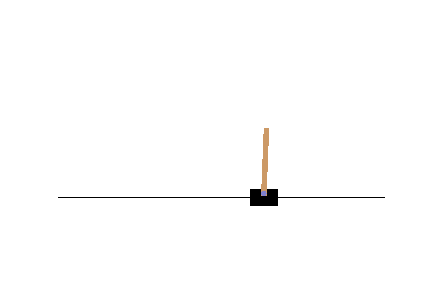
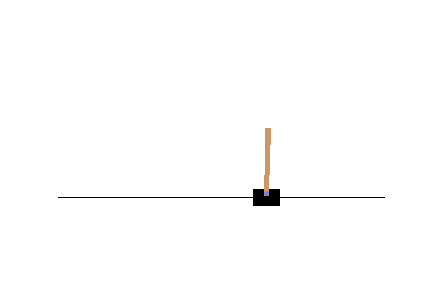
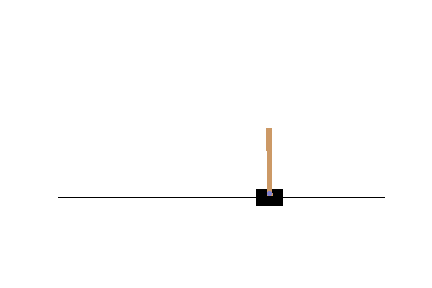
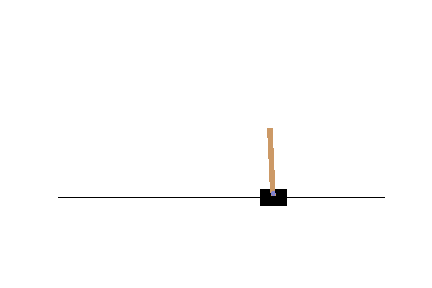
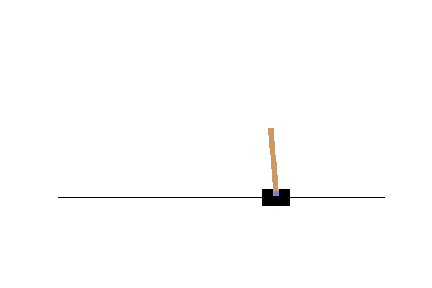
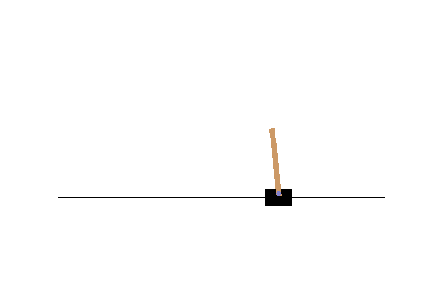
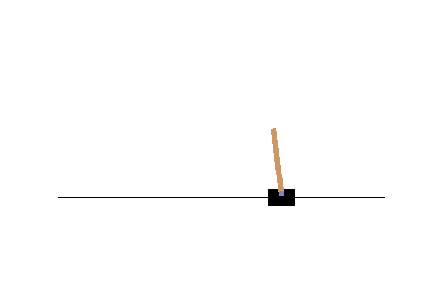
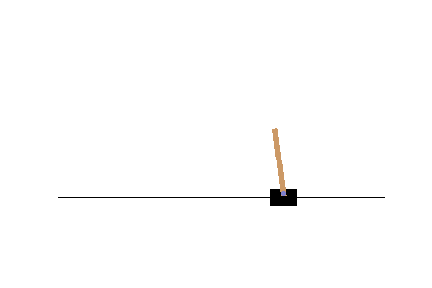
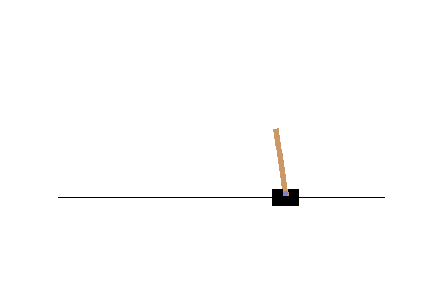
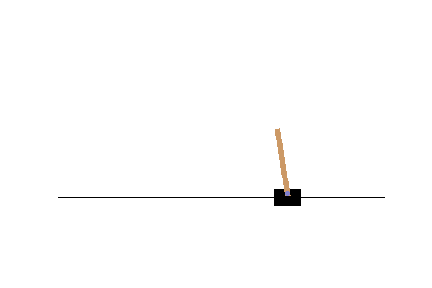
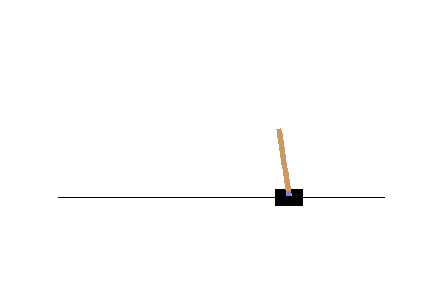
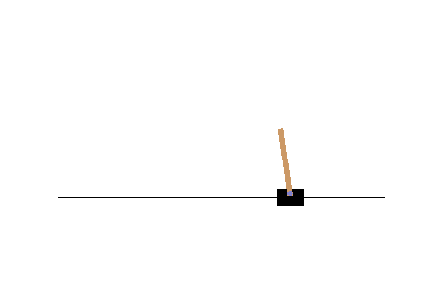
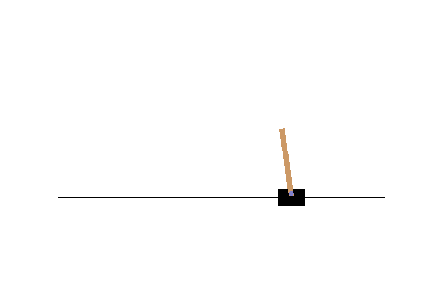
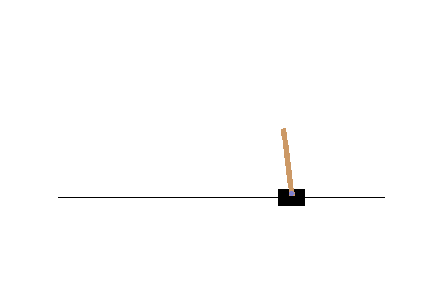
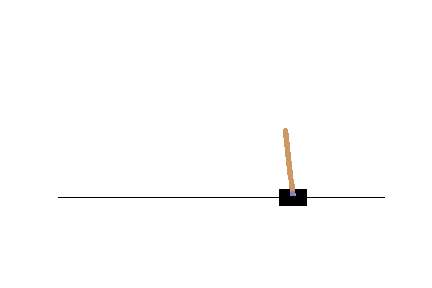
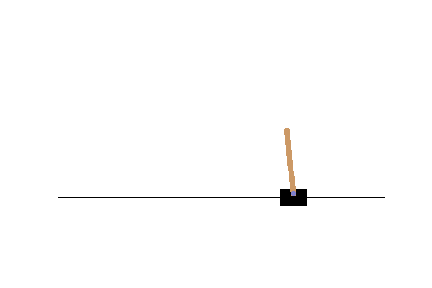
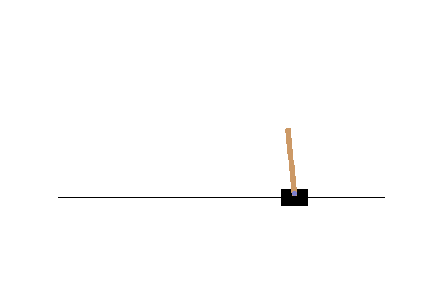
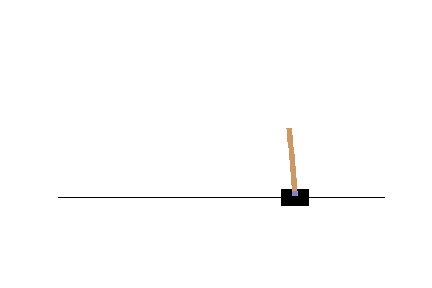
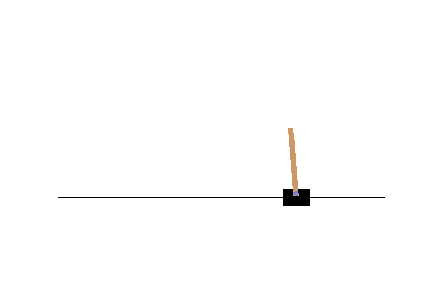
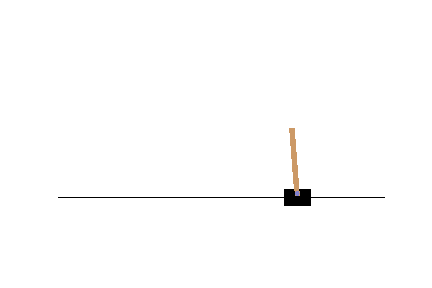
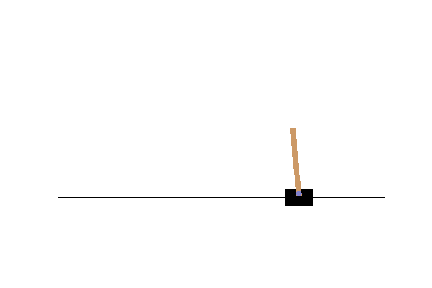
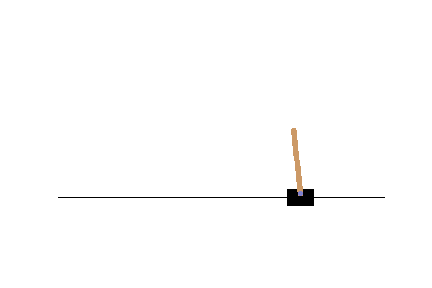
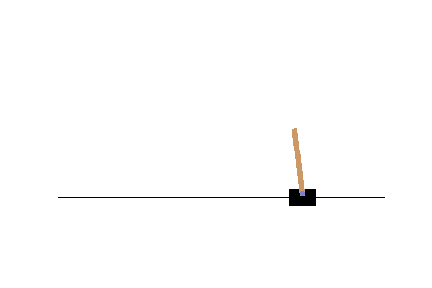
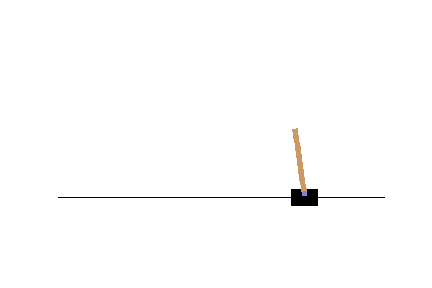
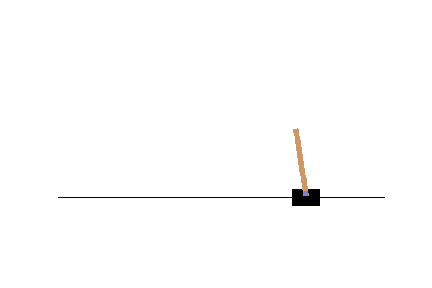
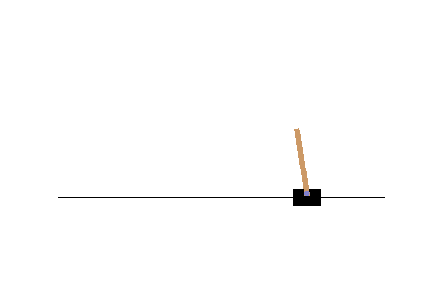
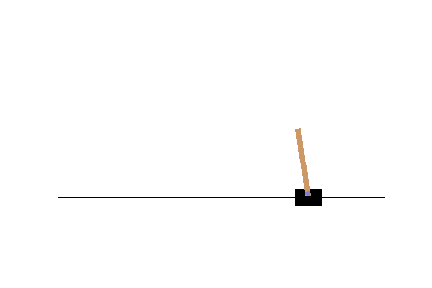
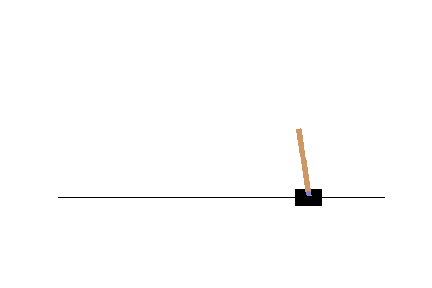
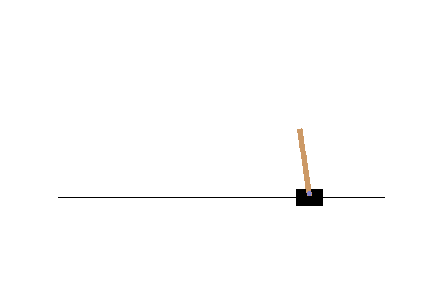
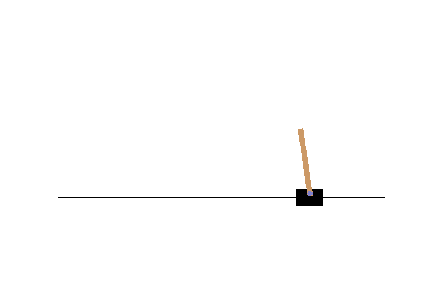
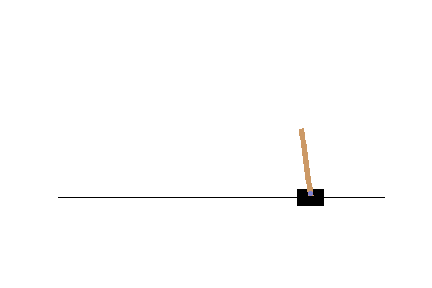
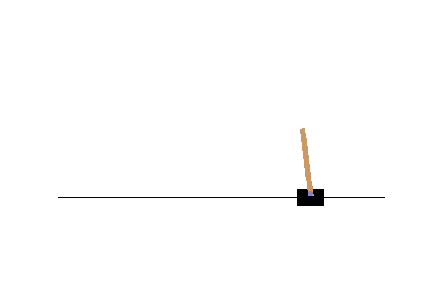
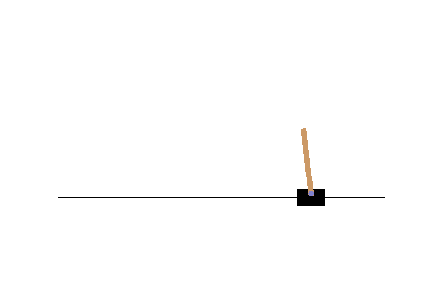
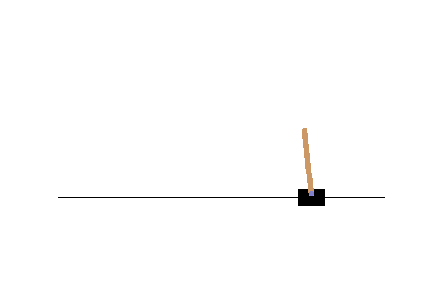
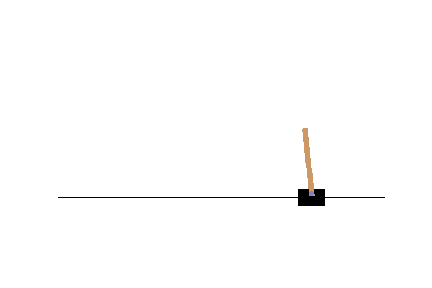
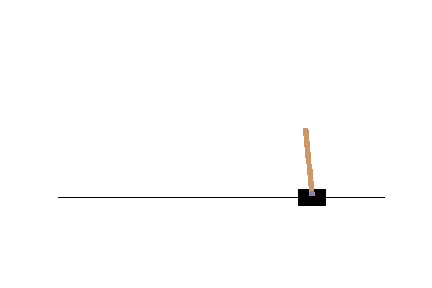
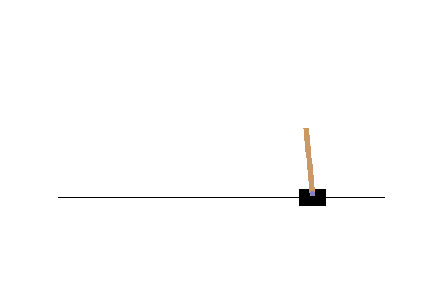
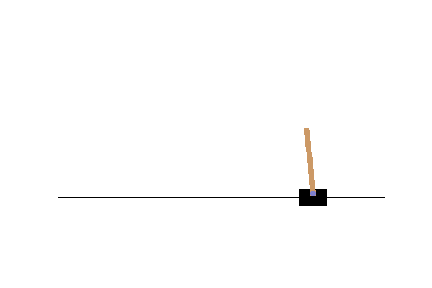
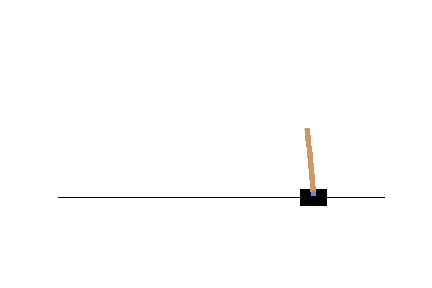
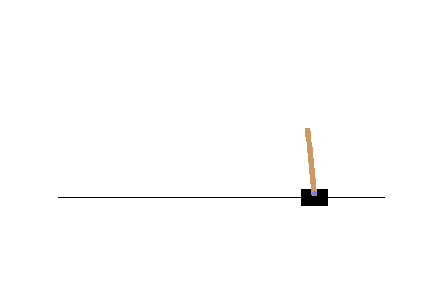
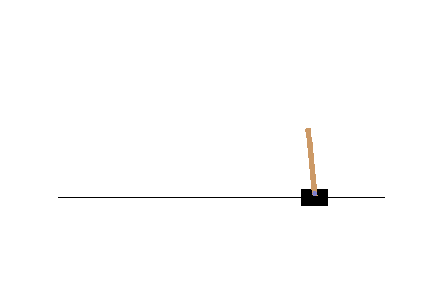
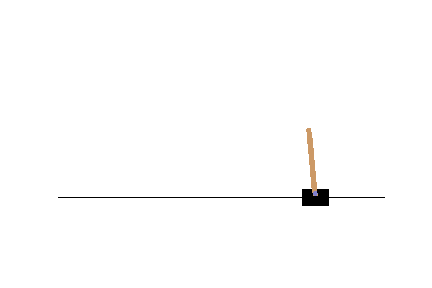
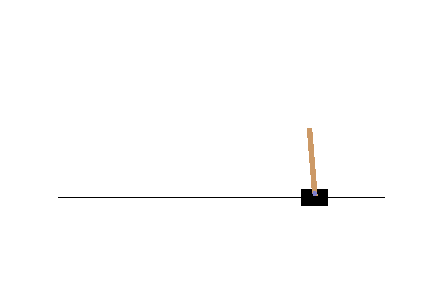
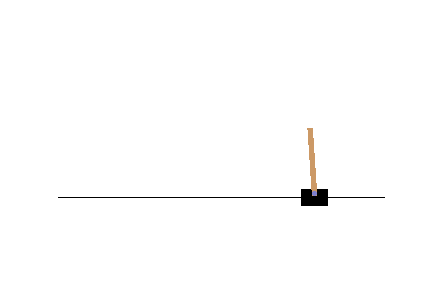
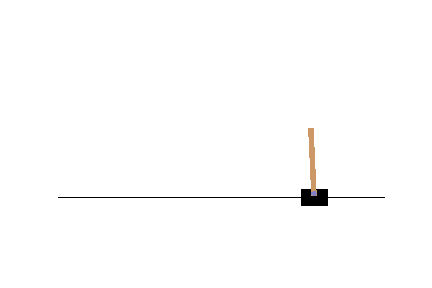
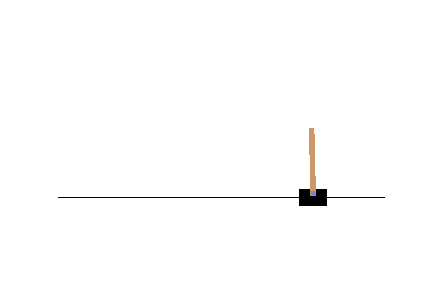
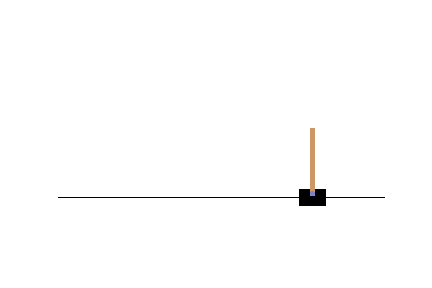
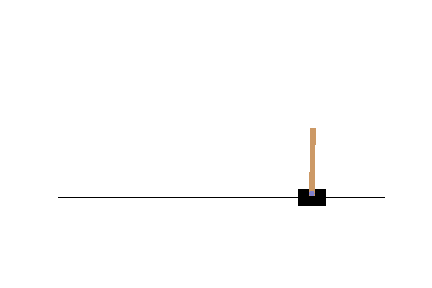
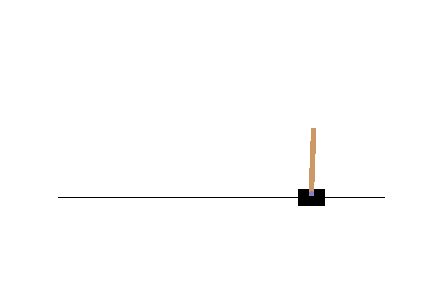
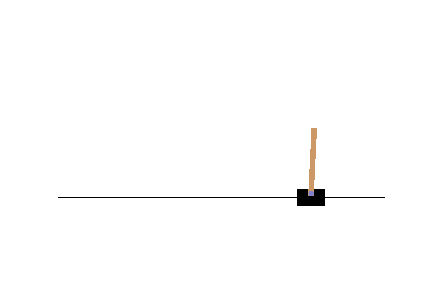
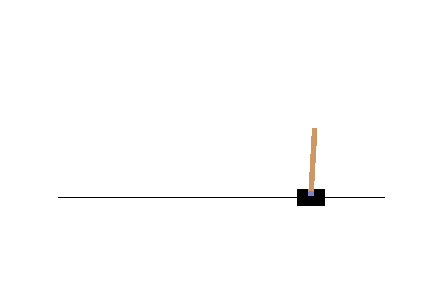
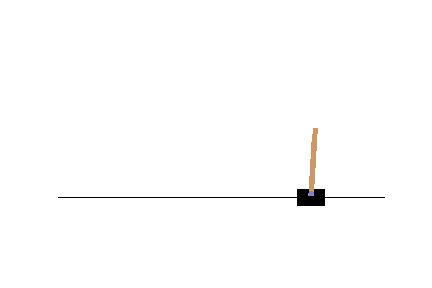
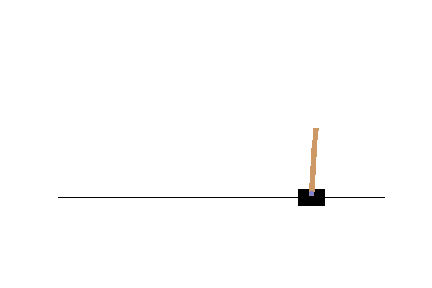
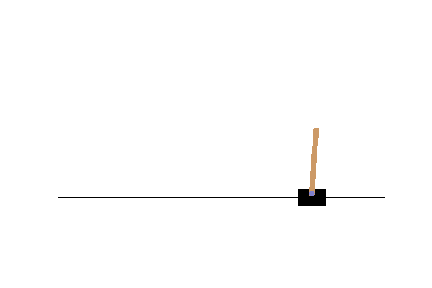
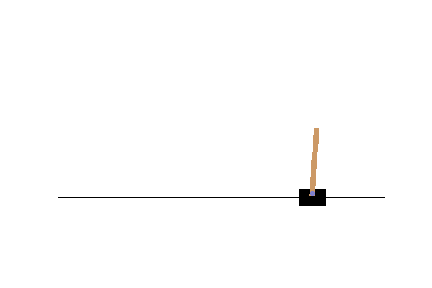
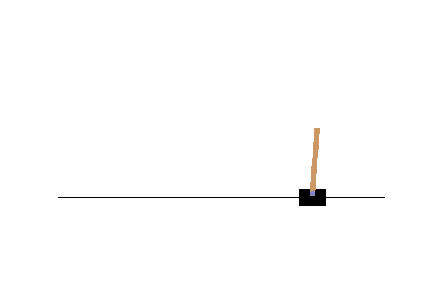
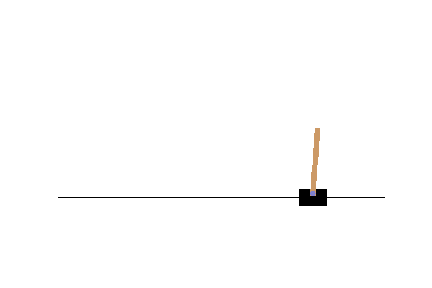
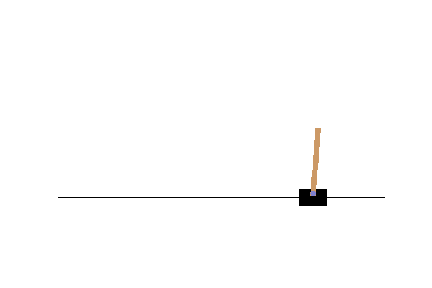
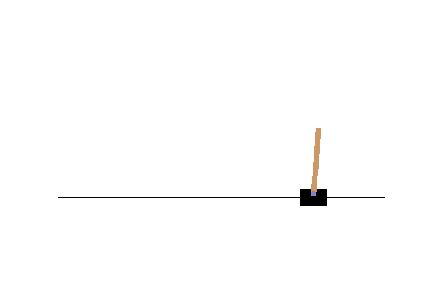
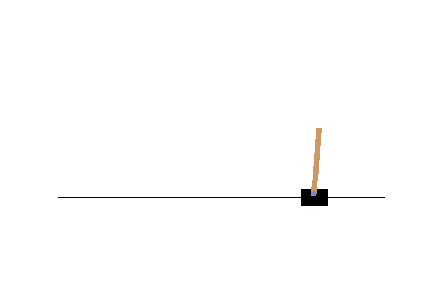
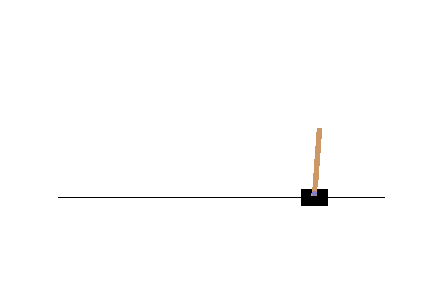
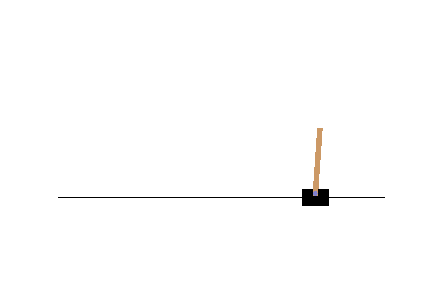
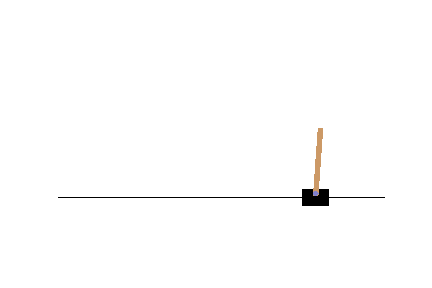
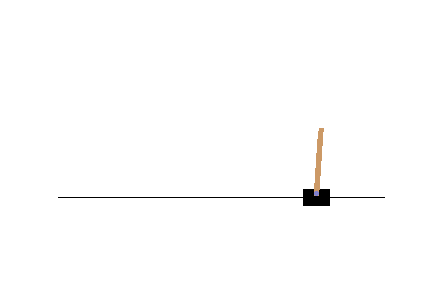
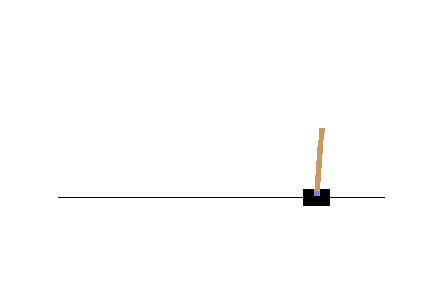
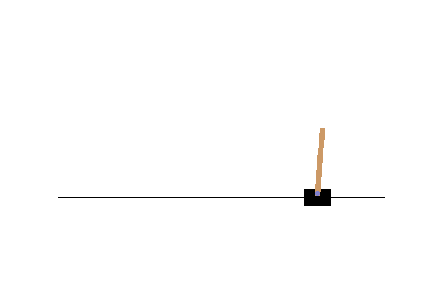
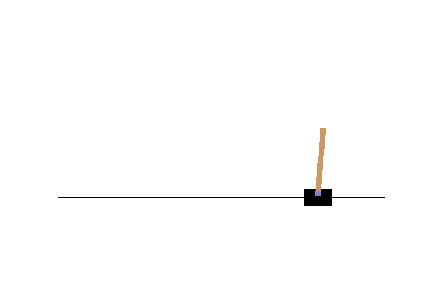
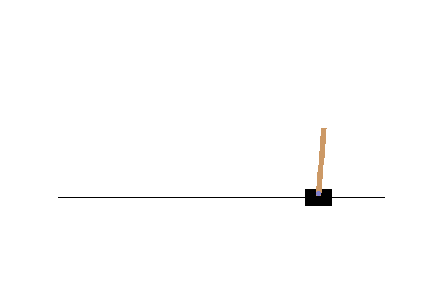
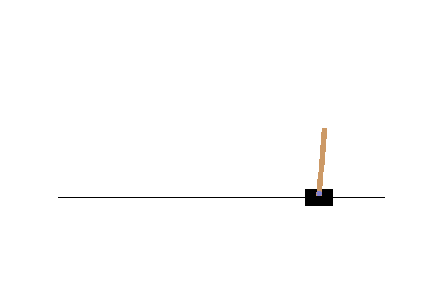
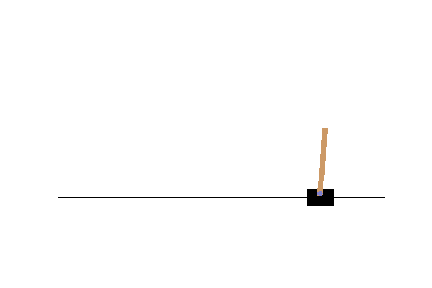
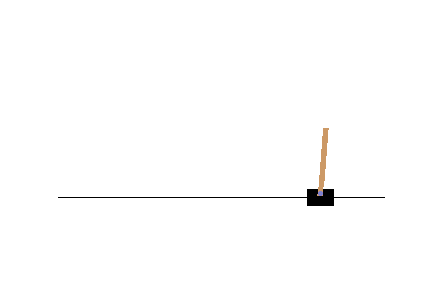
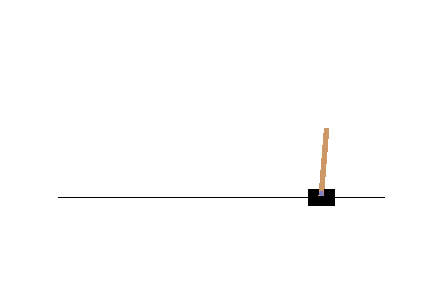
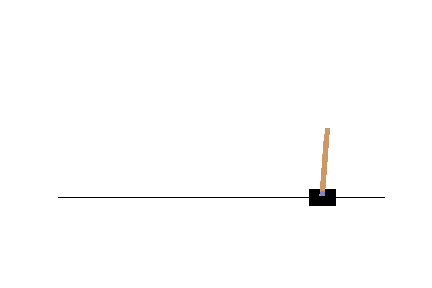
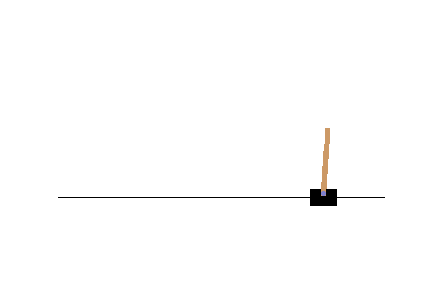
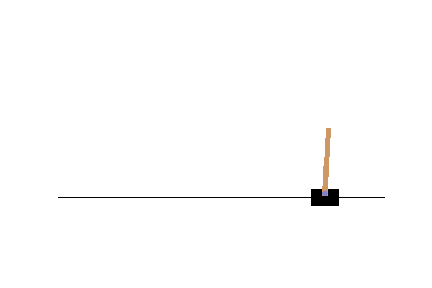
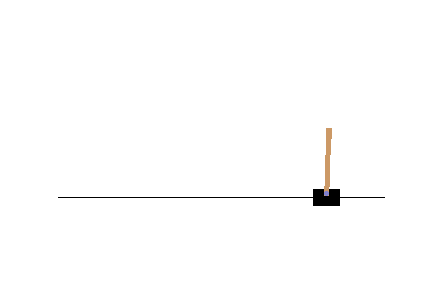
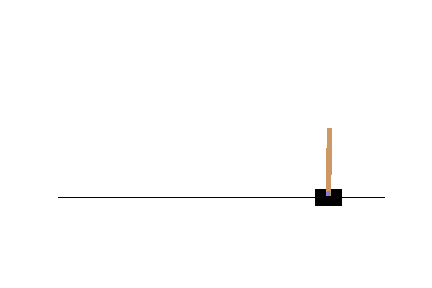
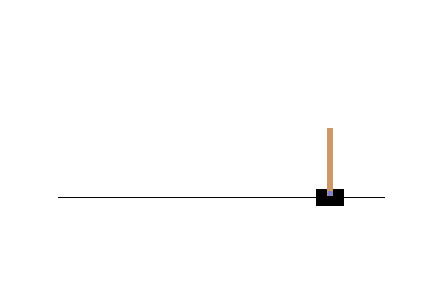
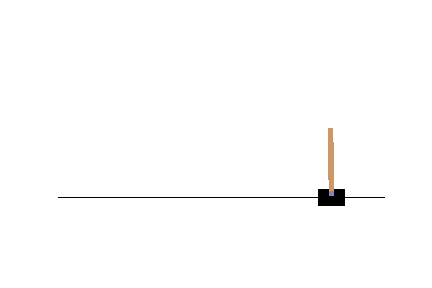
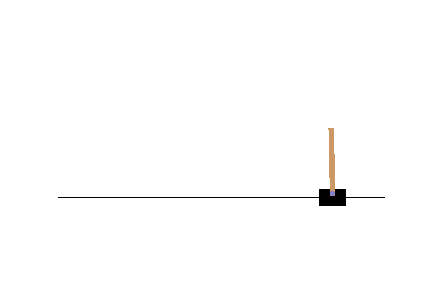
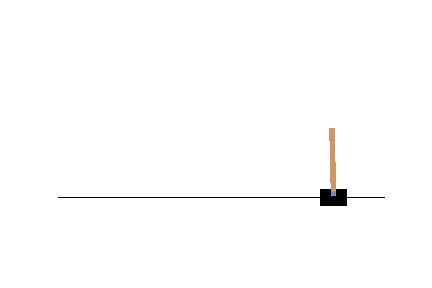
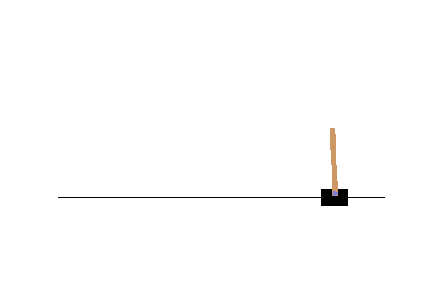
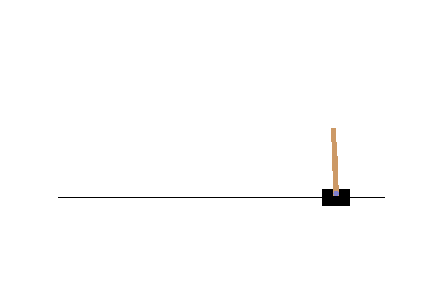
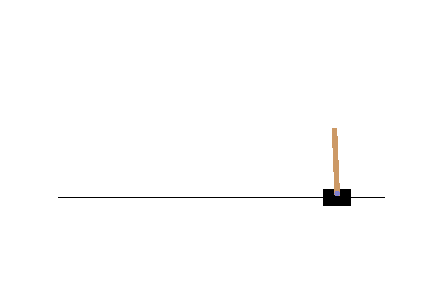
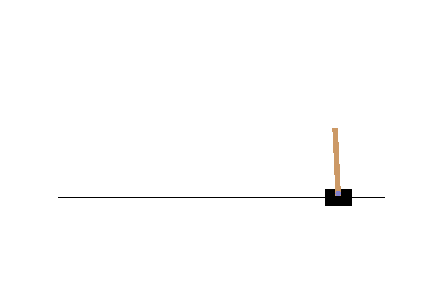
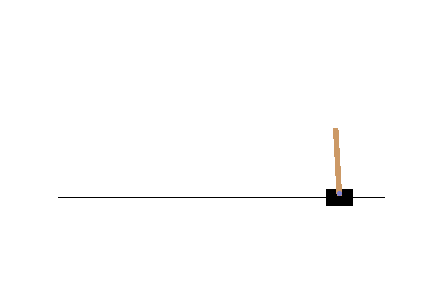
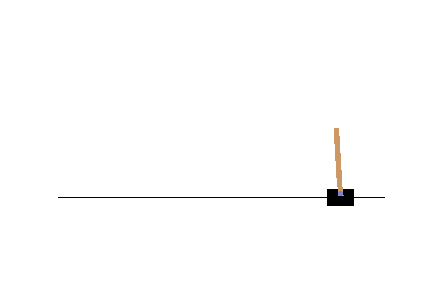
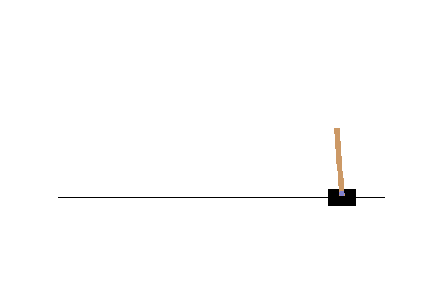
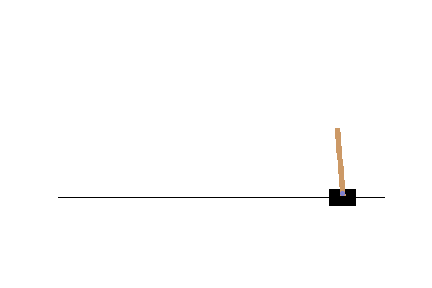
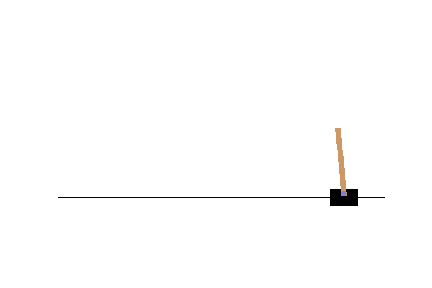
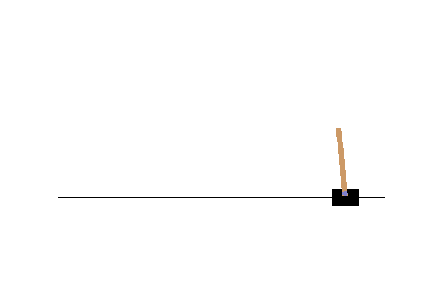
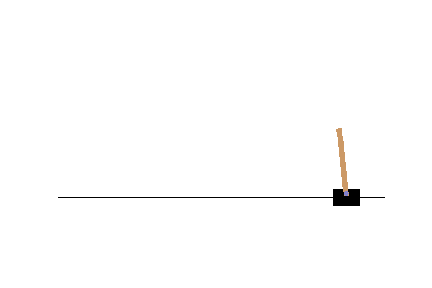
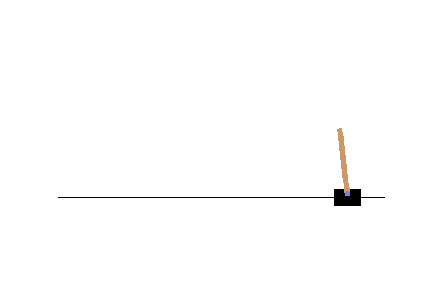
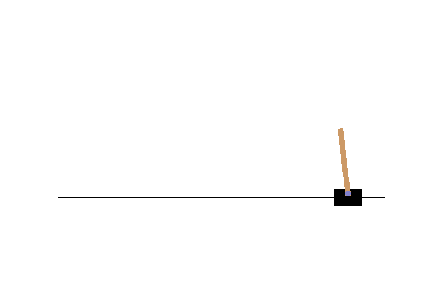
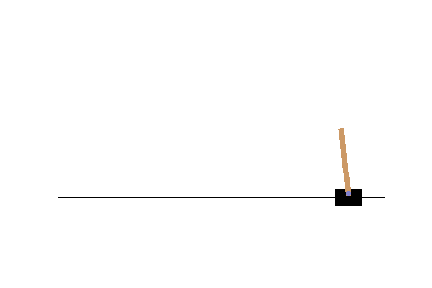
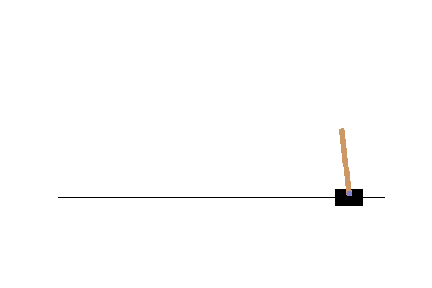
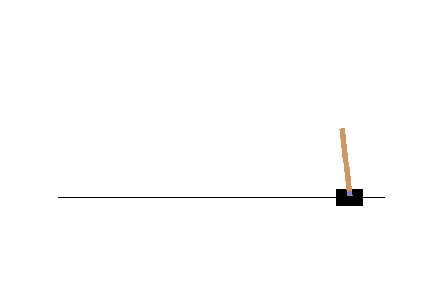
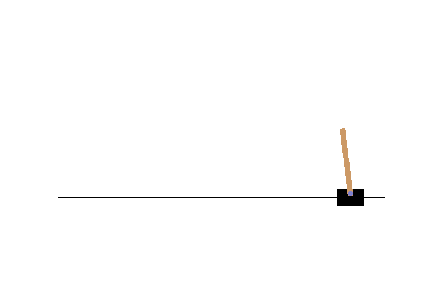
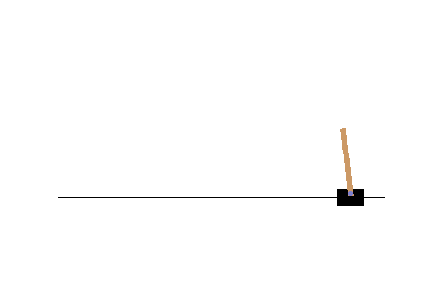
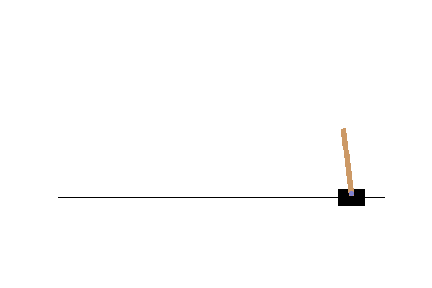
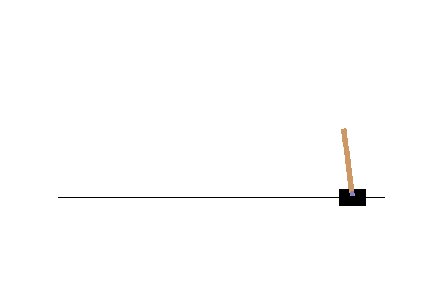
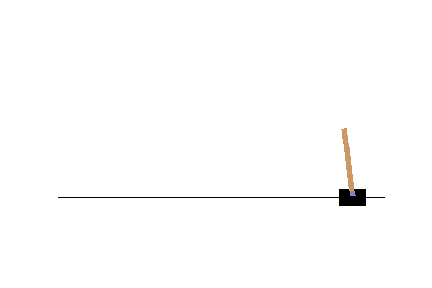
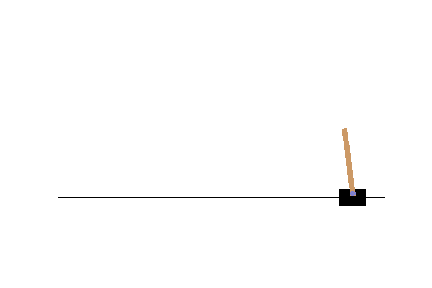
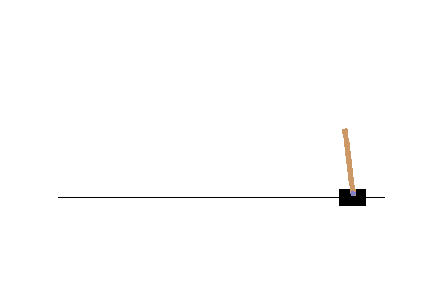
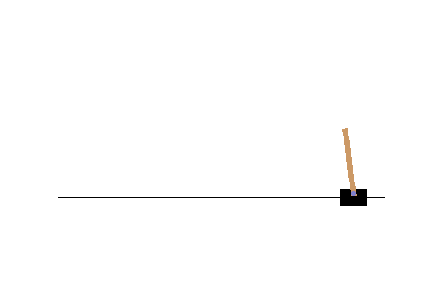
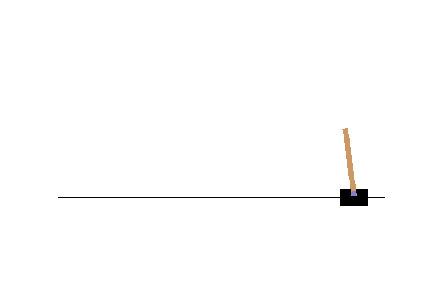
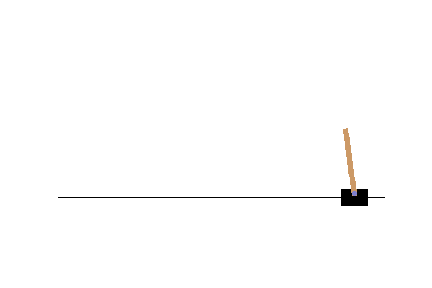
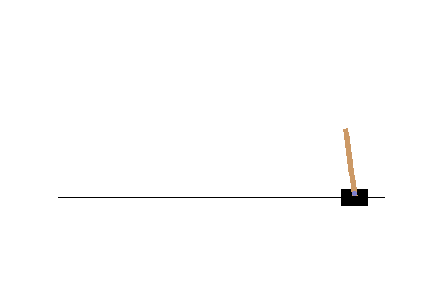
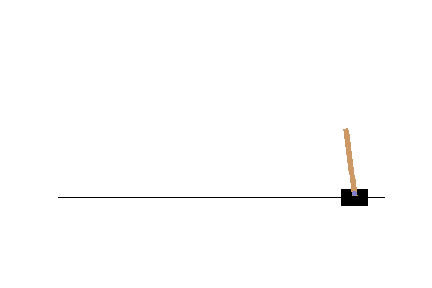
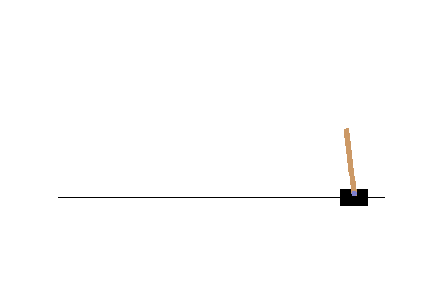
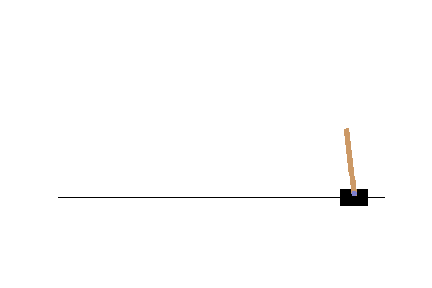
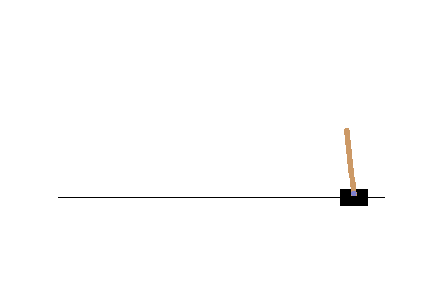
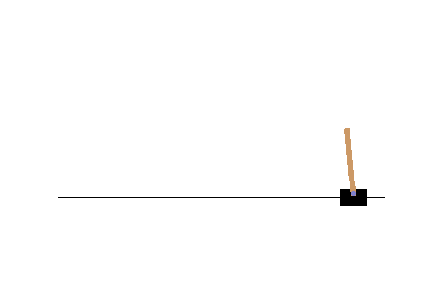
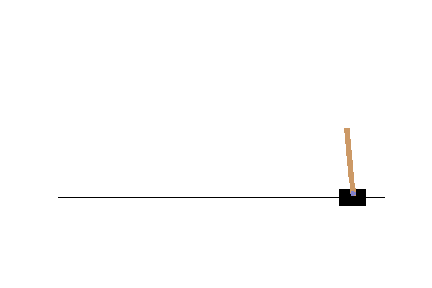
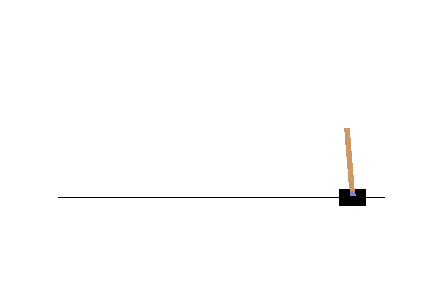
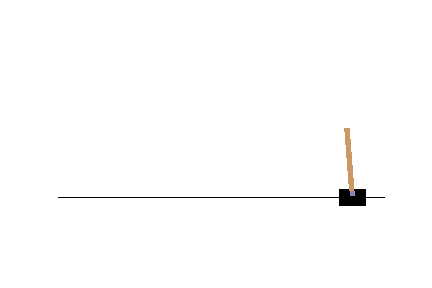
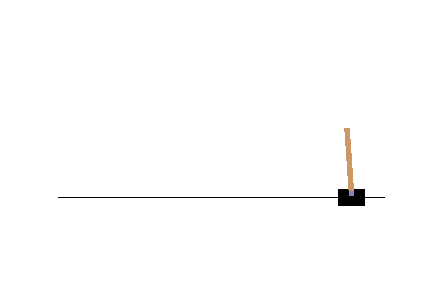
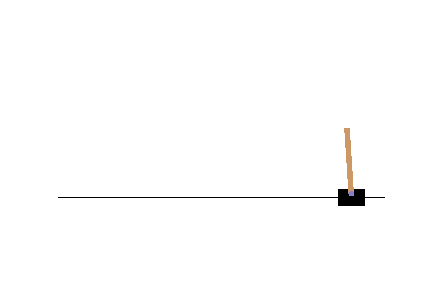
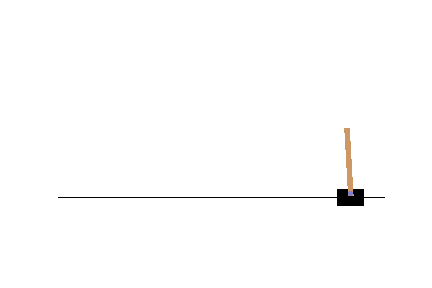
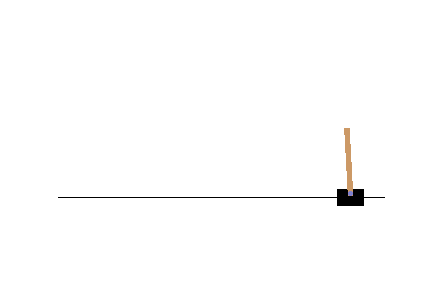
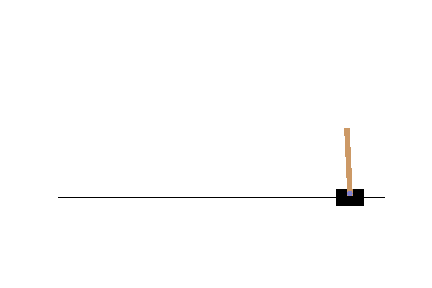
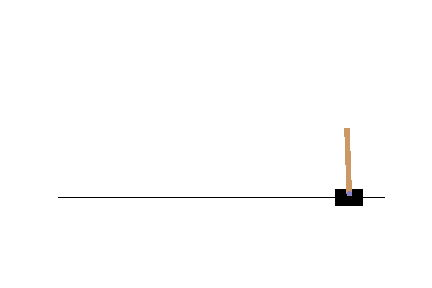
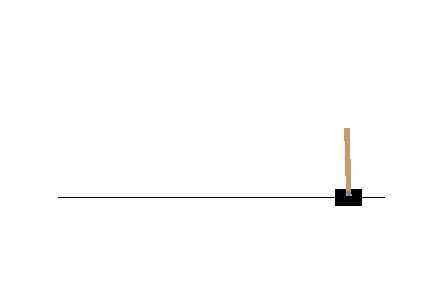
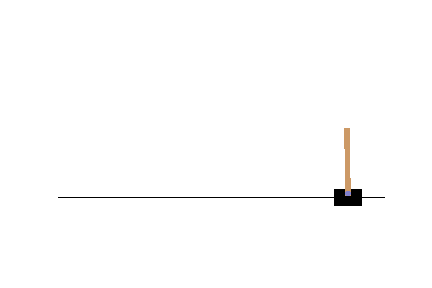
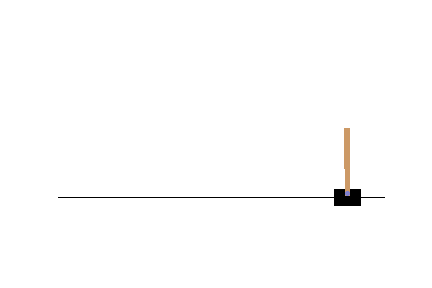
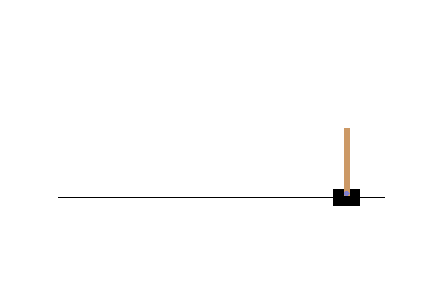
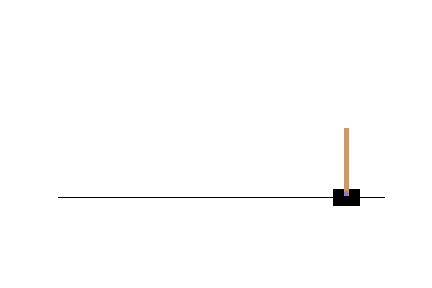
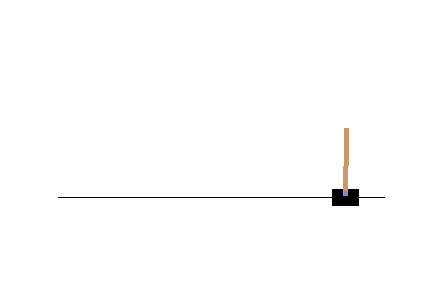
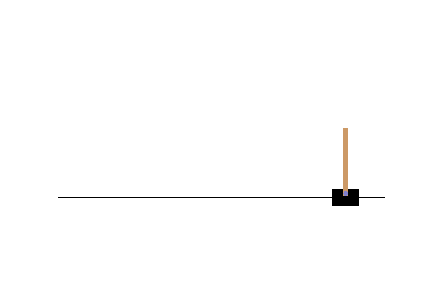
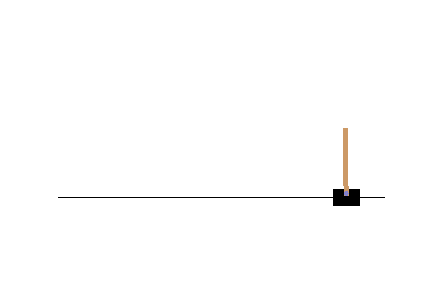
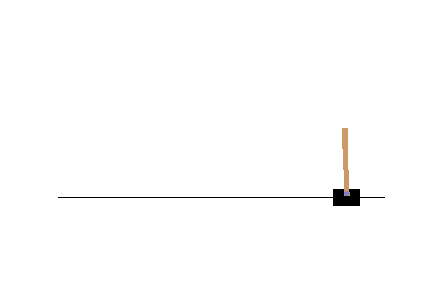
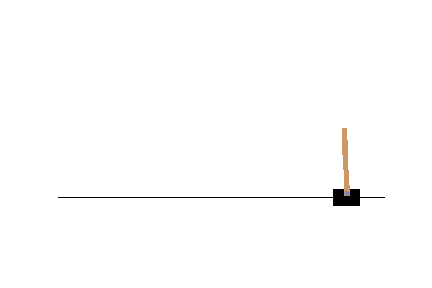
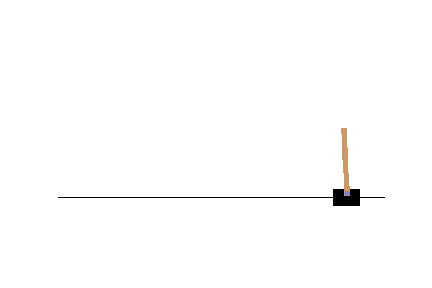
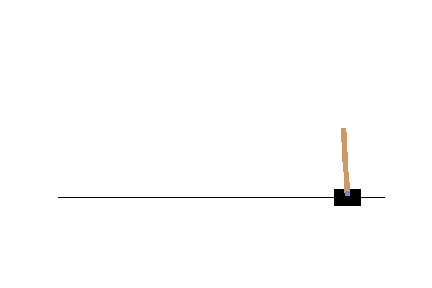
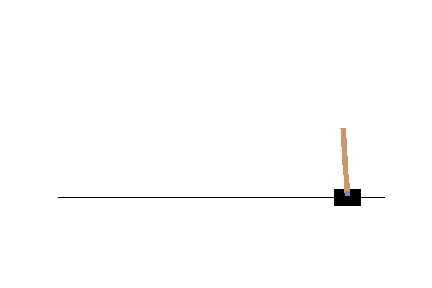
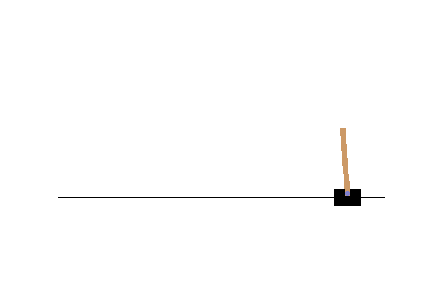
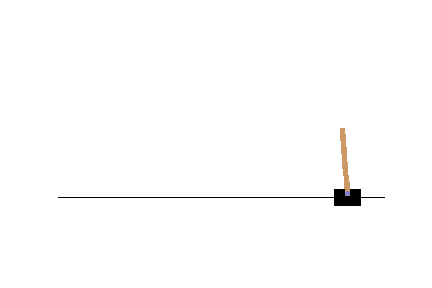
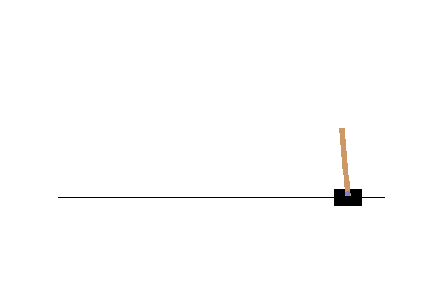

In [6]:
observation = env.reset()

frames = []
for _ in range(num_max_step):
    state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
    action = learning.get_action(state, episode)
    observation, reward, done, info =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

## SARSA法で訓練

In [7]:
learning = QLearning(num_state, num_action)

observation = env.reset()

rewards_sarsa = []
rewards_goal_eval = np.zeros(num_goal_avg_episode)

for episode in range(num_max_episode):
    total_reward = 0
    observation = env.reset()
    state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
    action = learning.get_action(state, episode)
    
    for step in range(num_max_step):
        next_observation, reward, done, info =  env.step(action)
        if done:
            if step < num_max_step-5:
                reward = -200
            else:
                reward = 1
        next_state = learn.digitize_state(next_observation, observation_low, observation_hight, num_dizitized)
        next_action = learning.get_action(next_state, episode)
        learning.update_q_table_sarsa(action, next_action, state, next_state, reward)
        total_reward += reward
        state = next_state
        action = next_action
        observation = next_observation
        if done:
            rewards_sarsa.append(total_reward)
            rewards_goal_eval = np.hstack((rewards_goal_eval[1:], total_reward))
            break
            
    # ゴール達成のため学習終了
    reward_avg = rewards_goal_eval.mean()
    if episode % 100 == 0:
        print('episode: {}, episode_reward: {}'.format(episode, reward_avg))
    if reward_avg >= goal_avg_rewaed:
        print('learning finished: {}'.format(episode))
        break

episode: 0, episode_reward: -18.3
episode: 100, episode_reward: -61.7
episode: 200, episode_reward: -49.0
episode: 300, episode_reward: -59.8
episode: 400, episode_reward: -21.1
episode: 500, episode_reward: -55.3
episode: 600, episode_reward: -59.5
episode: 700, episode_reward: -11.8
episode: 800, episode_reward: -62.6
episode: 900, episode_reward: -46.9
episode: 1000, episode_reward: -9.5
episode: 1100, episode_reward: -61.5
episode: 1200, episode_reward: 4.3
episode: 1300, episode_reward: 45.3
episode: 1400, episode_reward: -11.9
episode: 1500, episode_reward: 33.0
episode: 1600, episode_reward: 29.7
episode: 1700, episode_reward: -1.7
episode: 1800, episode_reward: 75.6
episode: 1900, episode_reward: 26.6
episode: 2000, episode_reward: 121.9
learning finished: 2079


### 学習後のQ値でシュミレーション


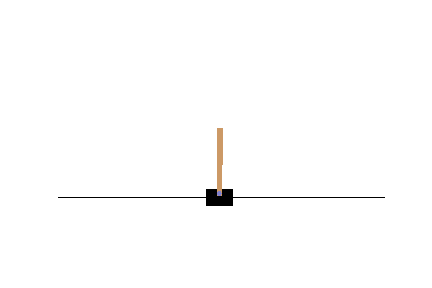
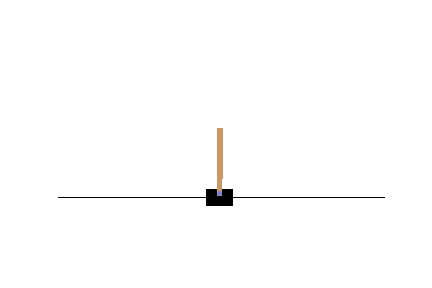
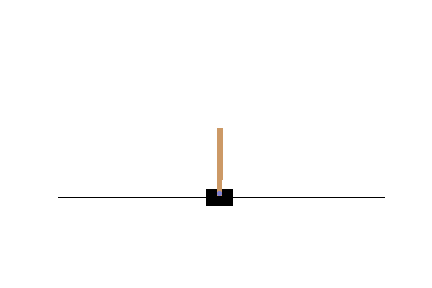
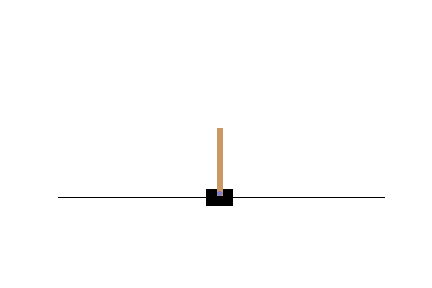
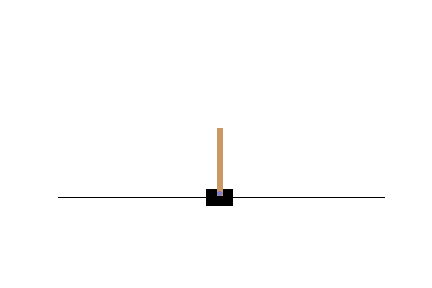
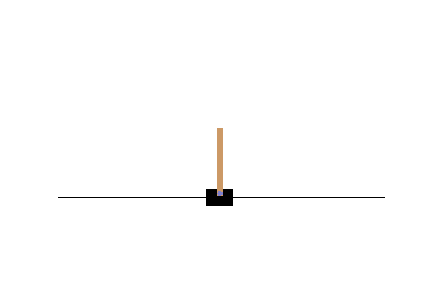
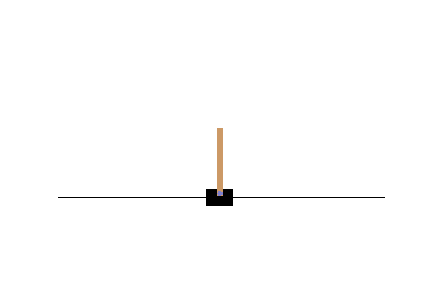
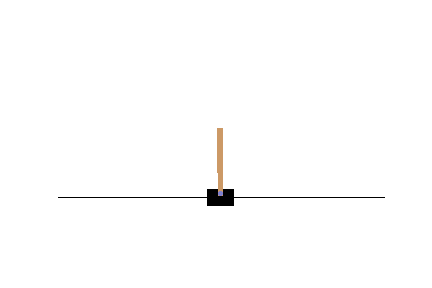
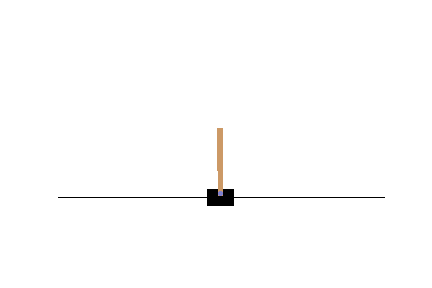
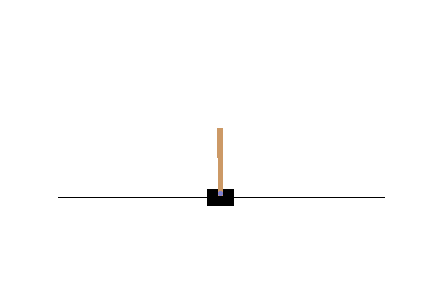
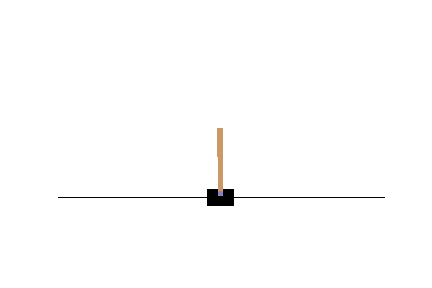
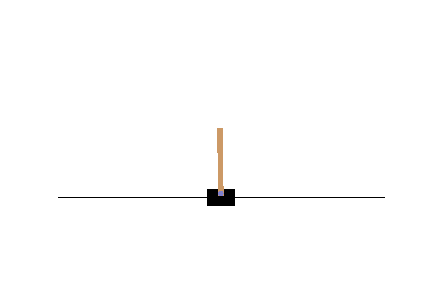
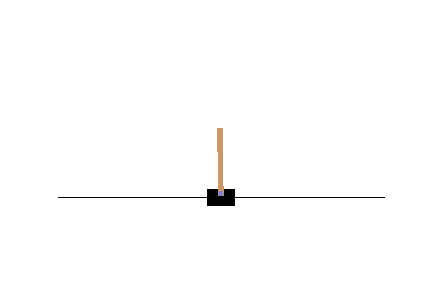
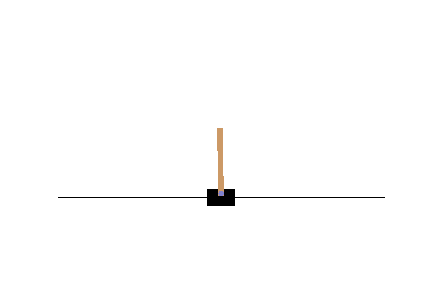
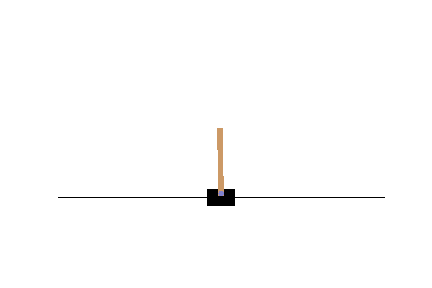
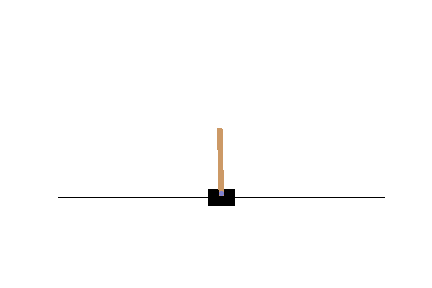
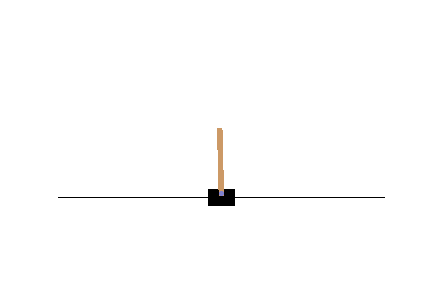
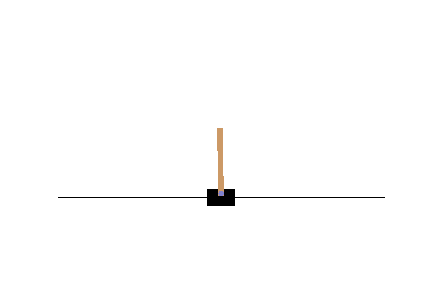
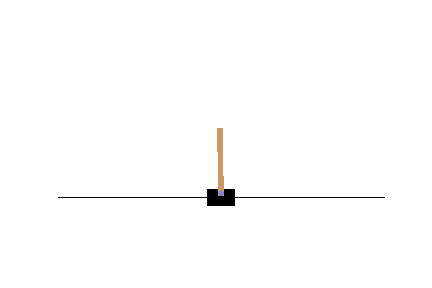
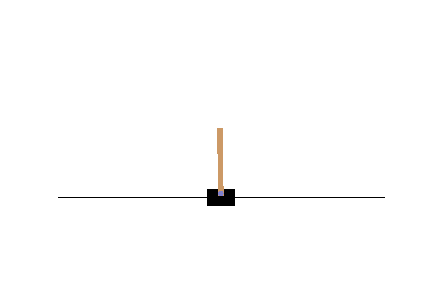
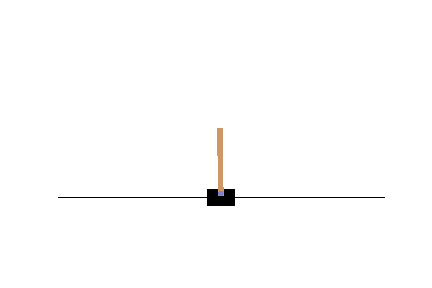
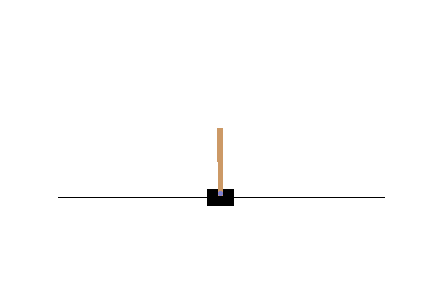
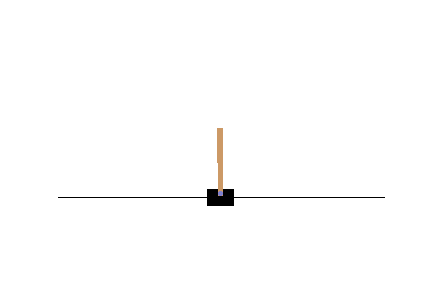
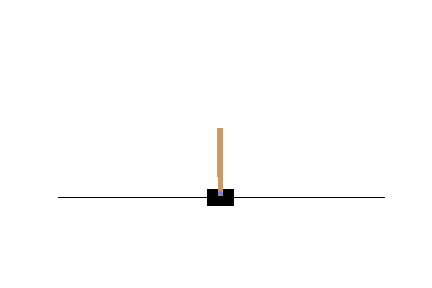
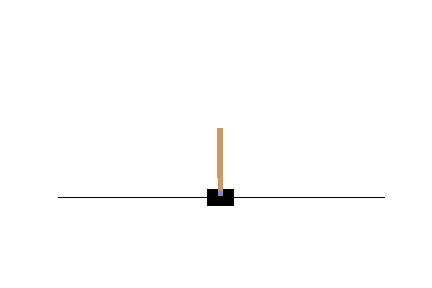
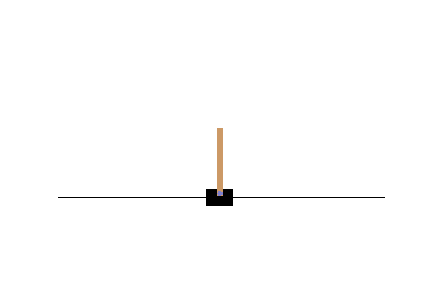
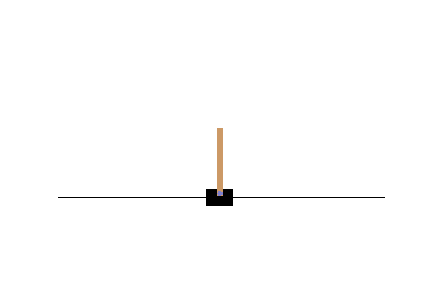
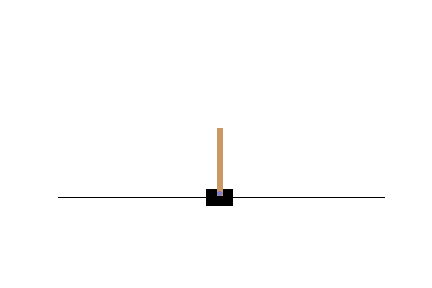
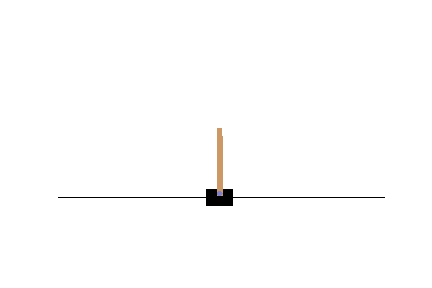
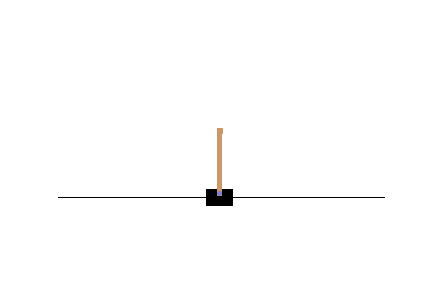
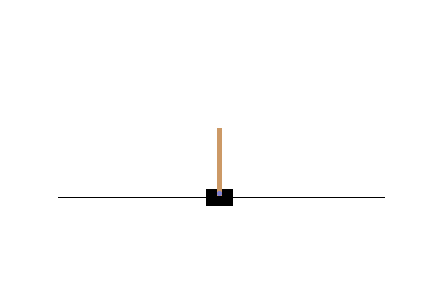
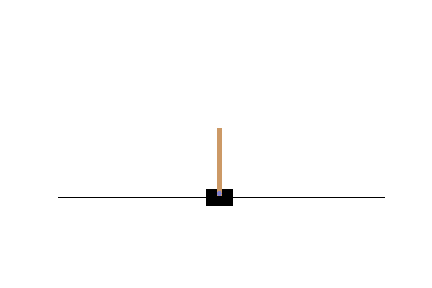
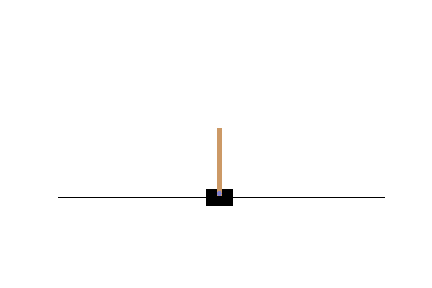
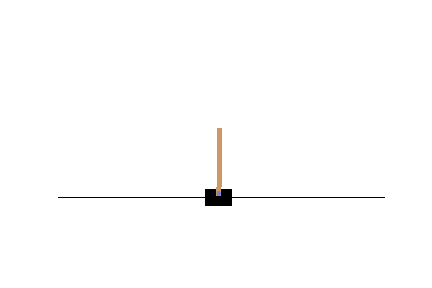
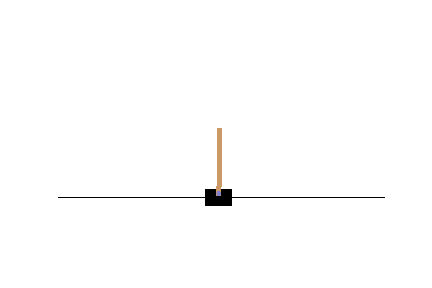
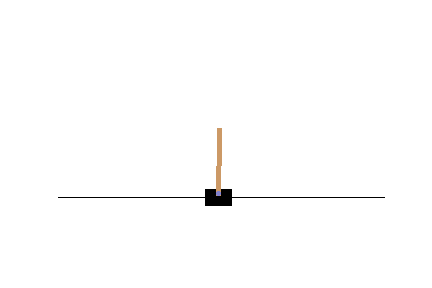
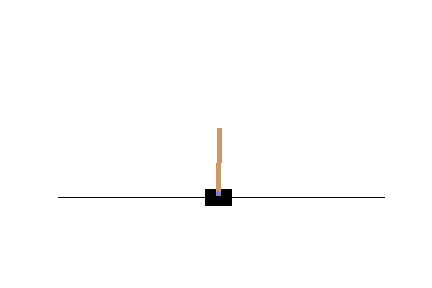
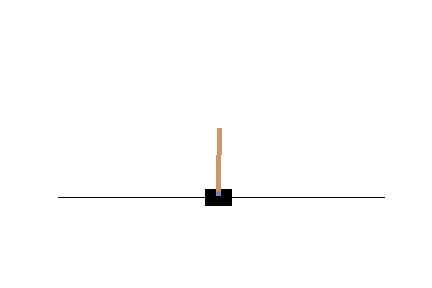
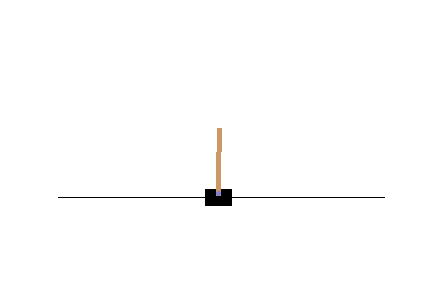
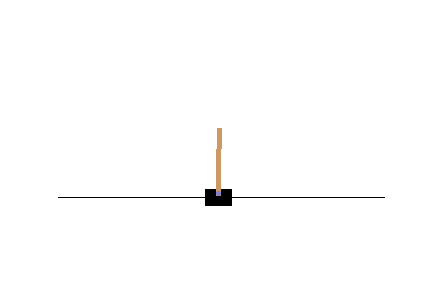
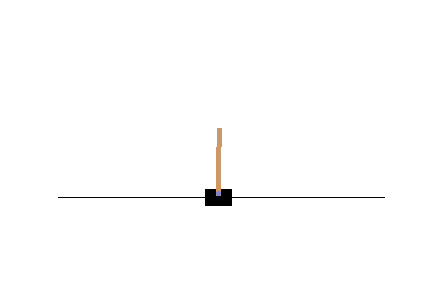
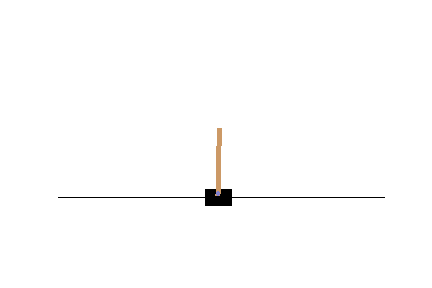
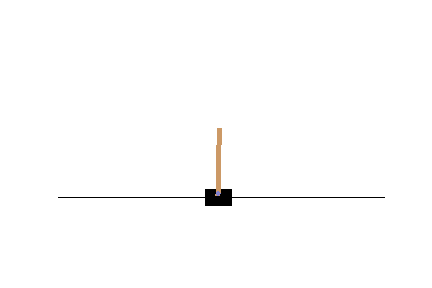
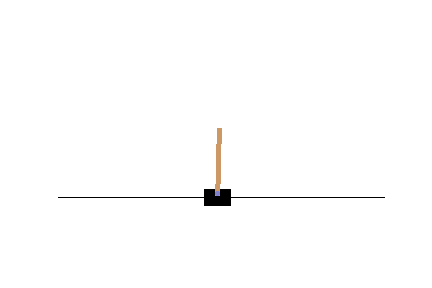
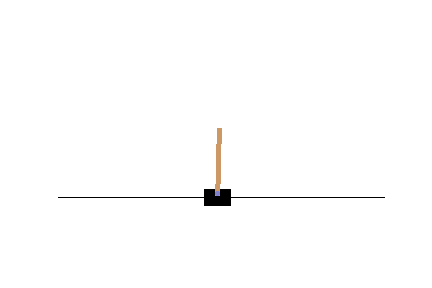
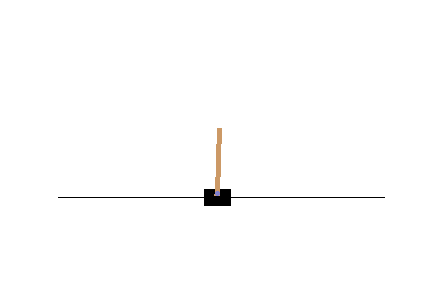
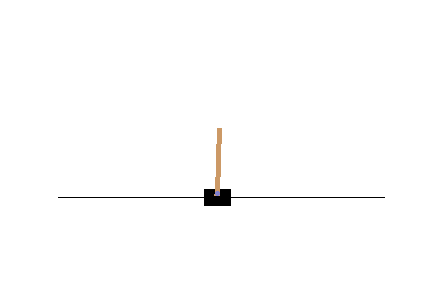
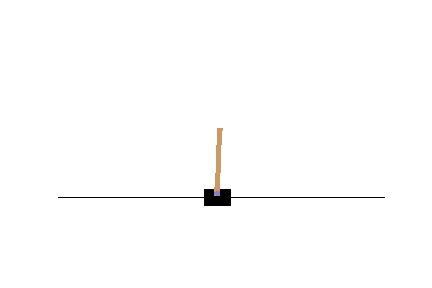
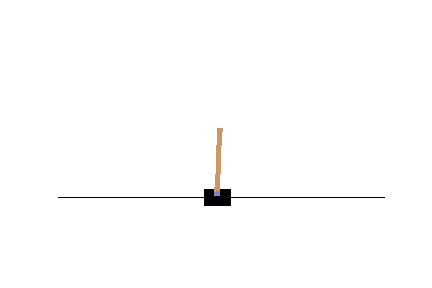
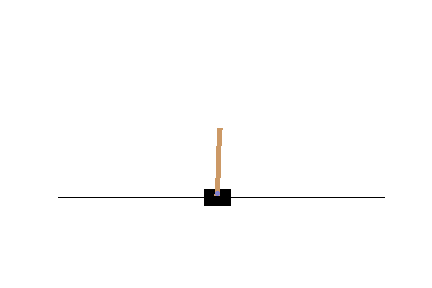
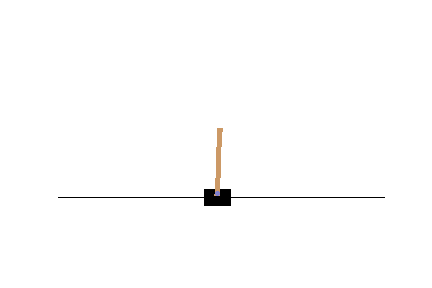
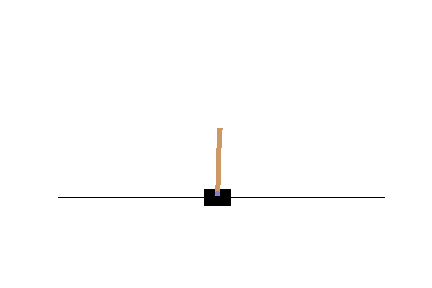
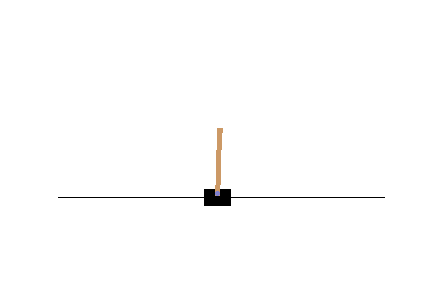
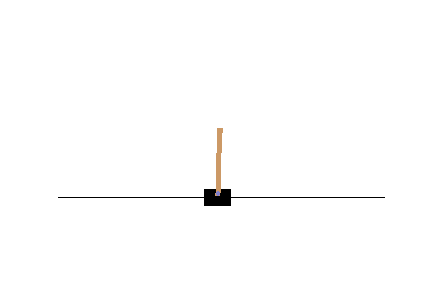
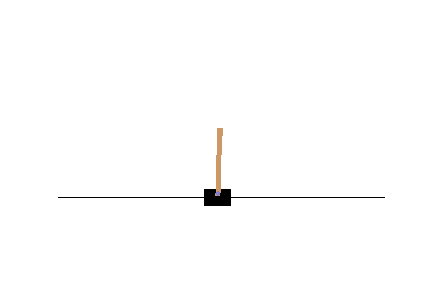
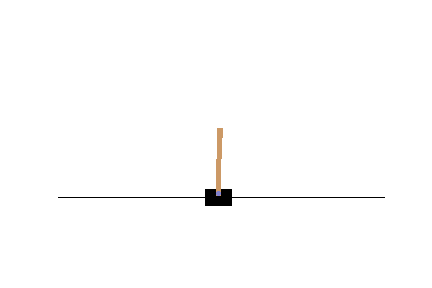
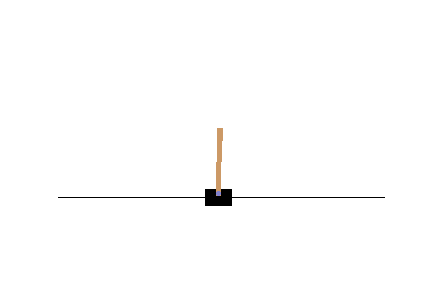
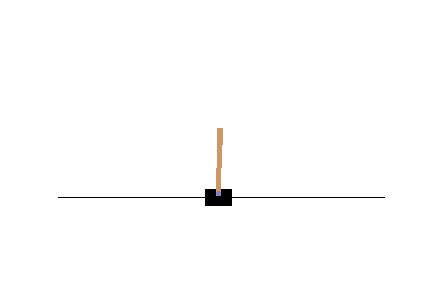
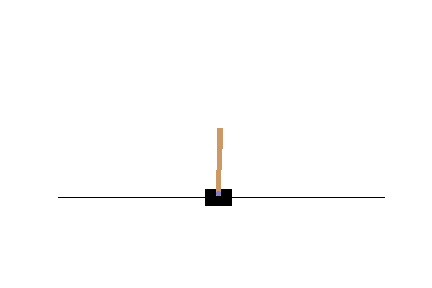
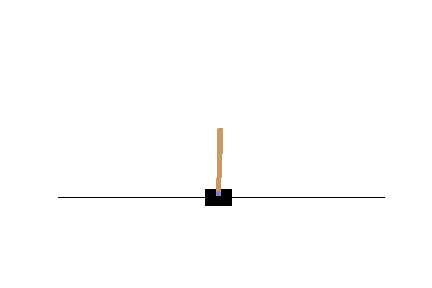
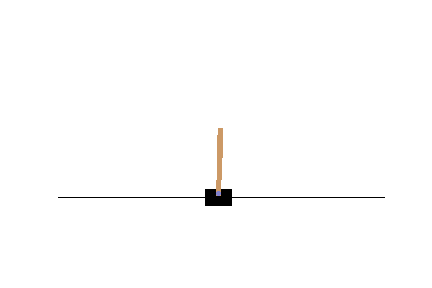
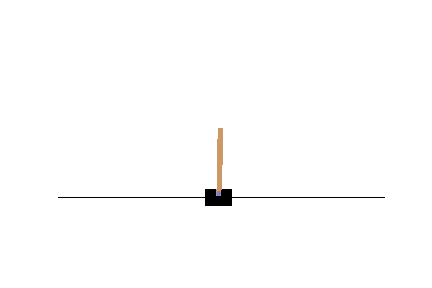
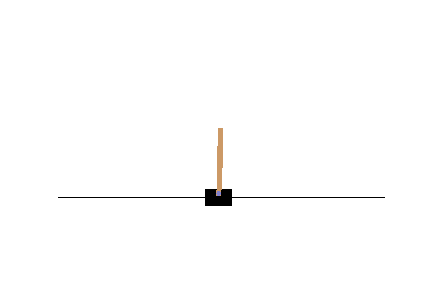
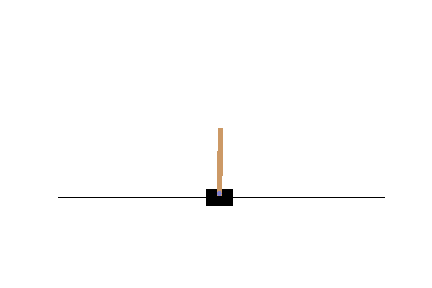
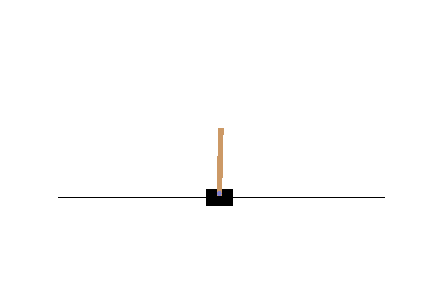
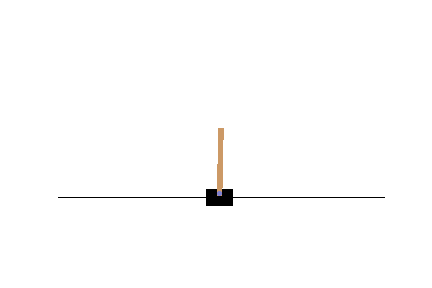
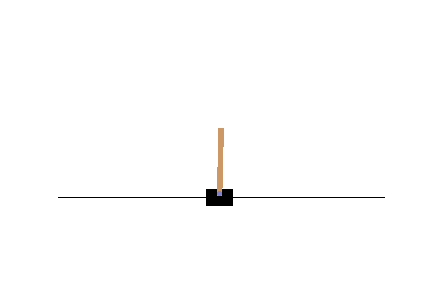
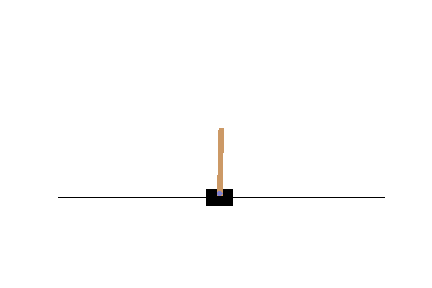
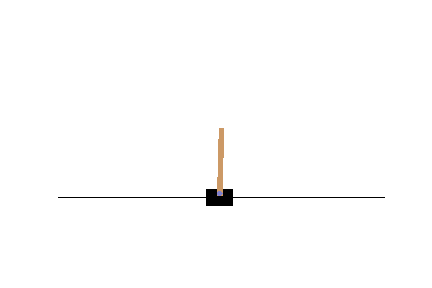
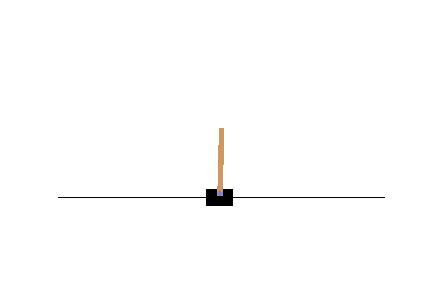
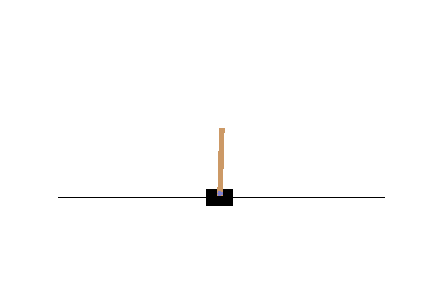
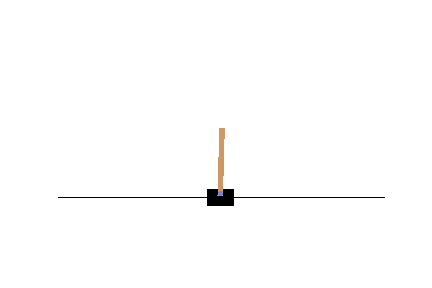
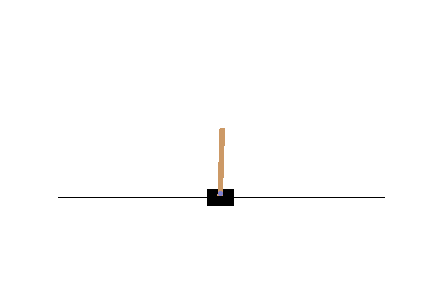
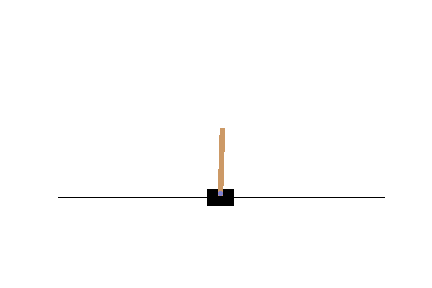
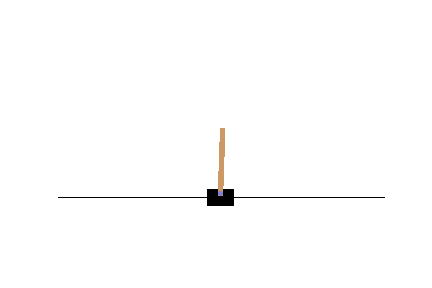
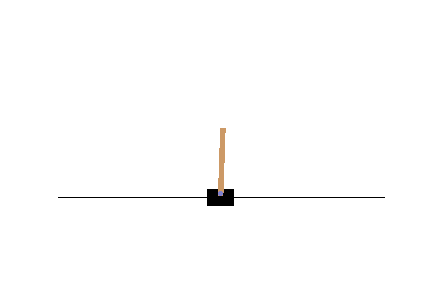
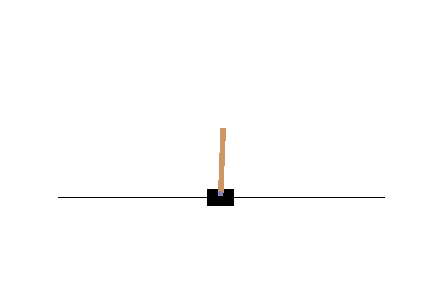
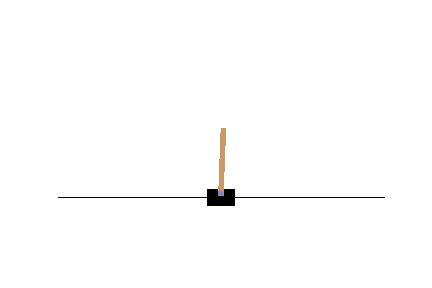
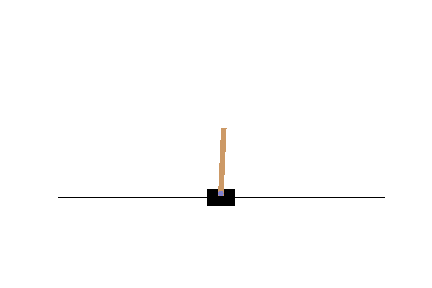
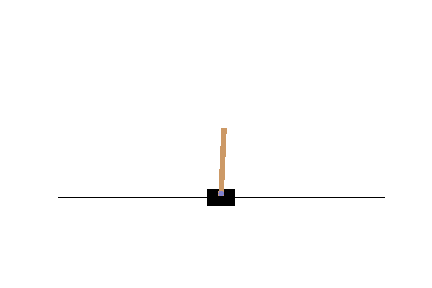
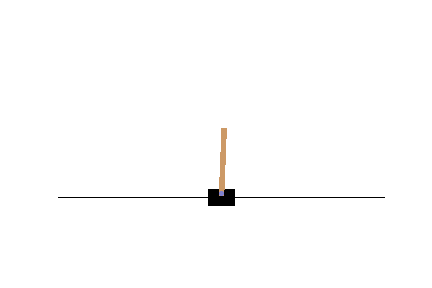
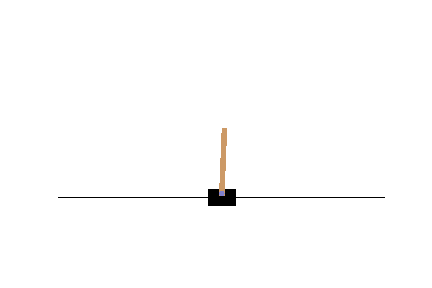
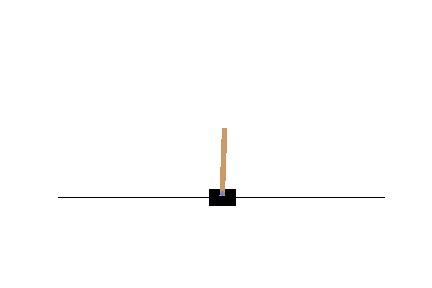
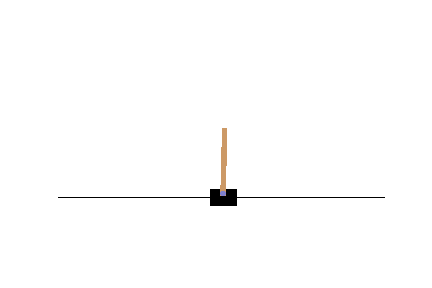
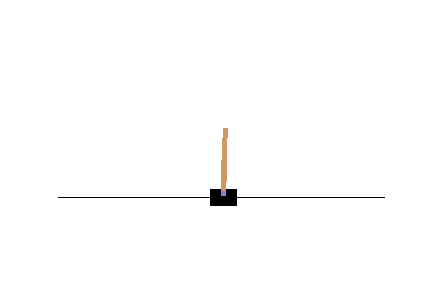
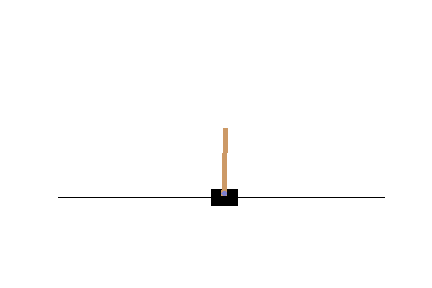
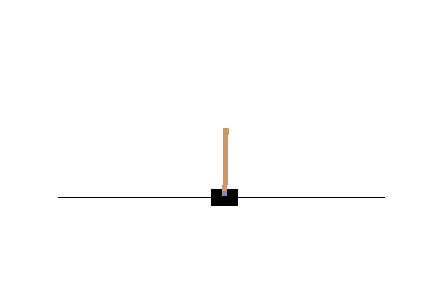
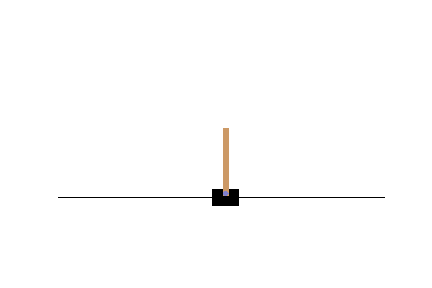
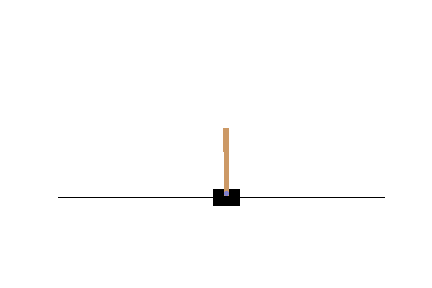
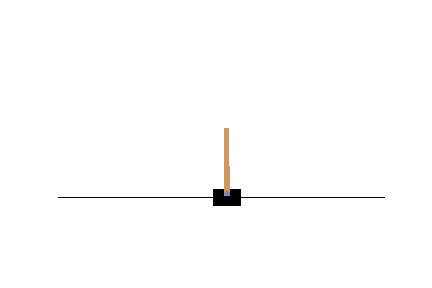
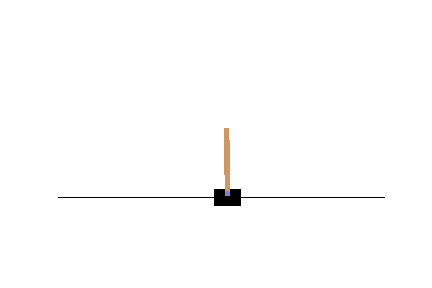
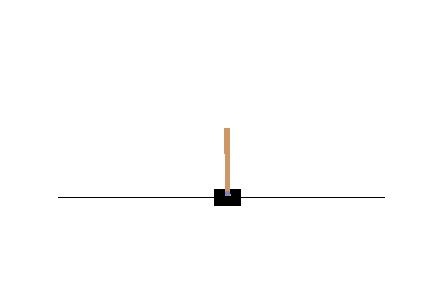
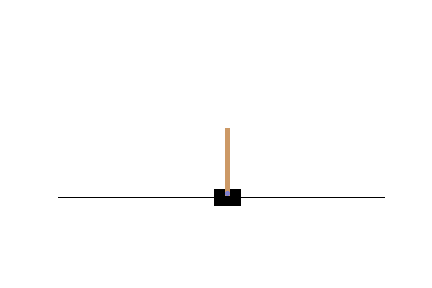
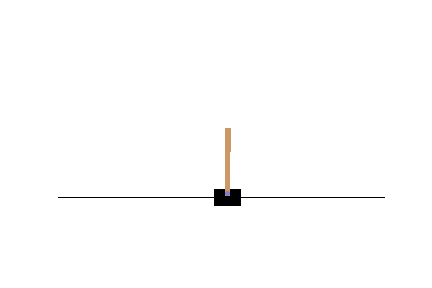
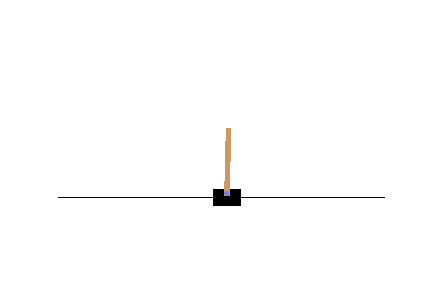
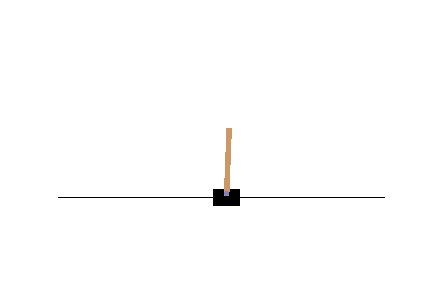
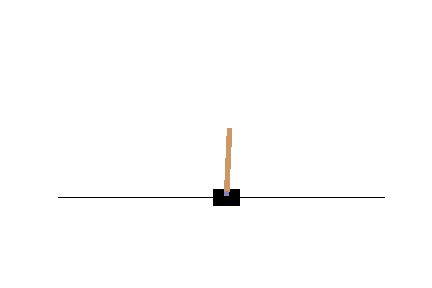
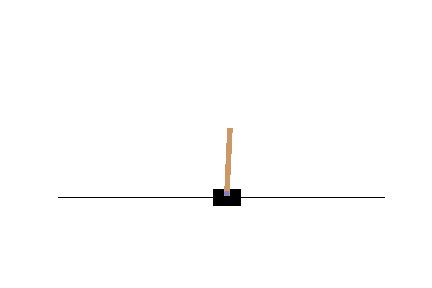
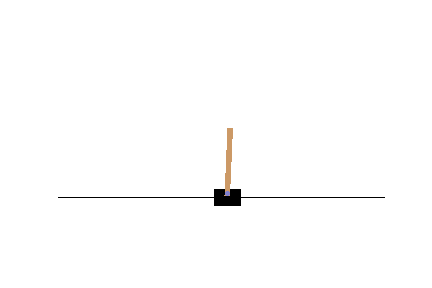
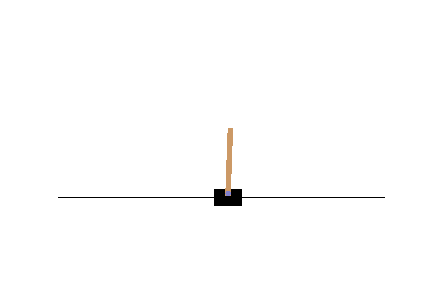
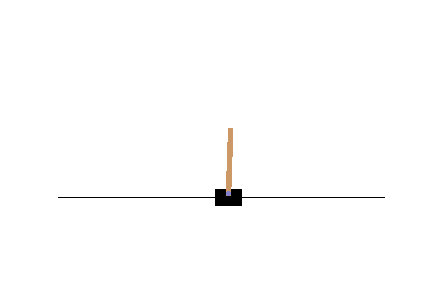
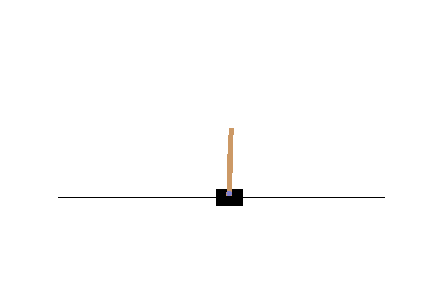
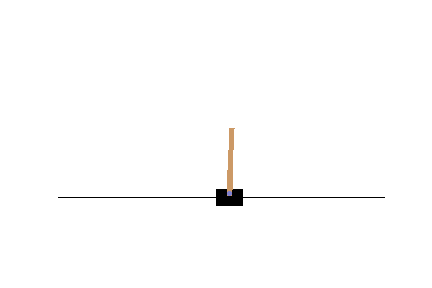
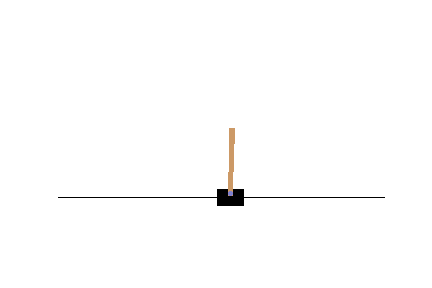
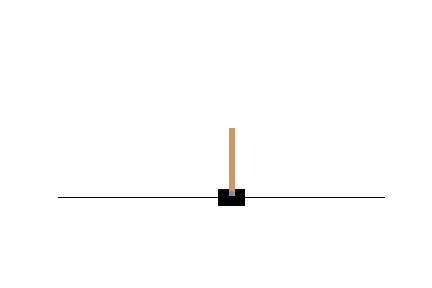
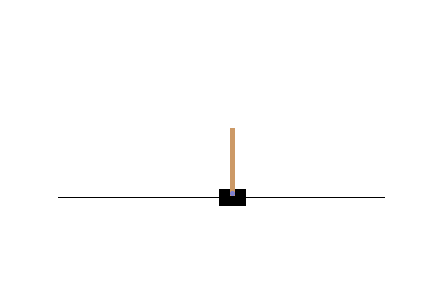
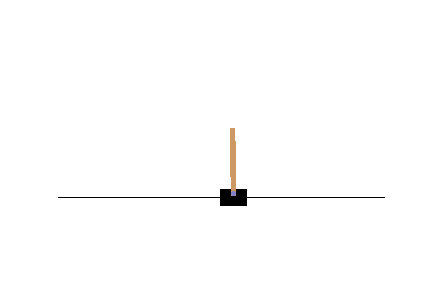
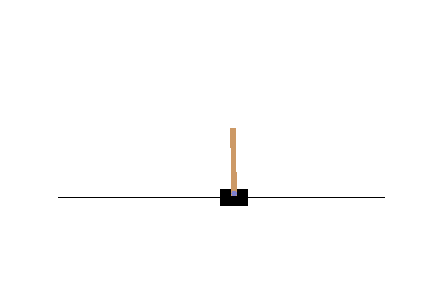
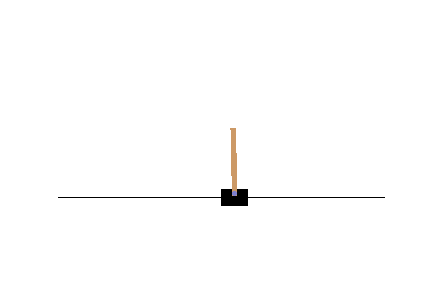
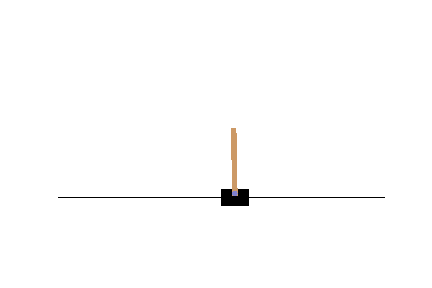
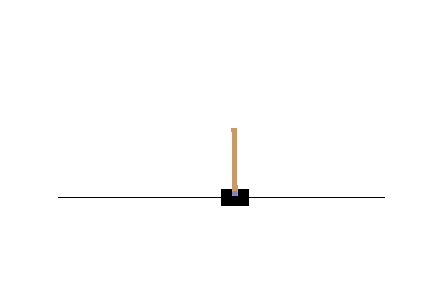
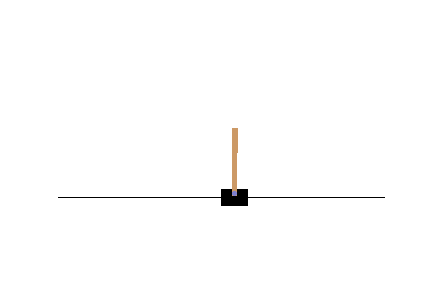
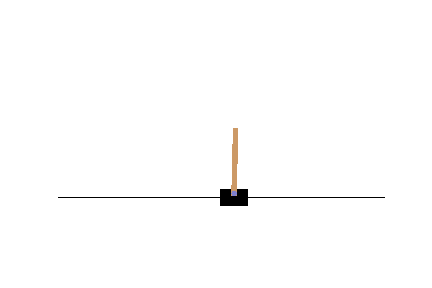
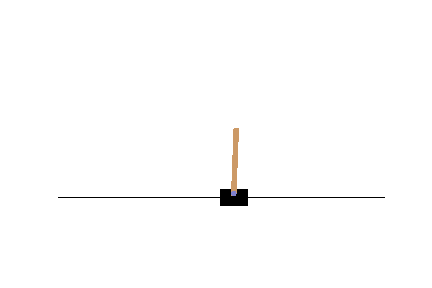
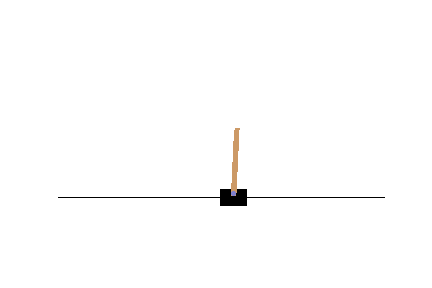
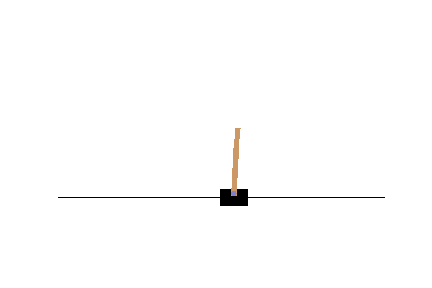
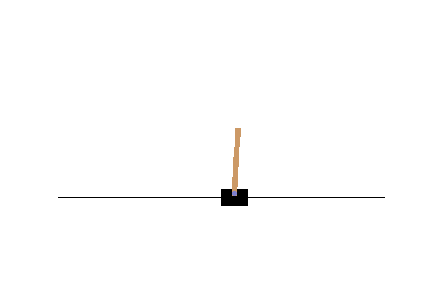
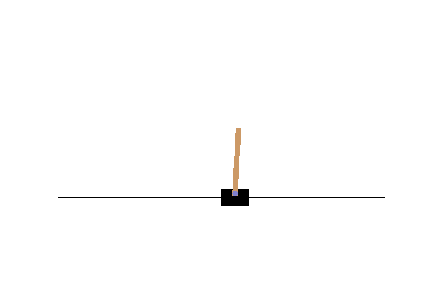
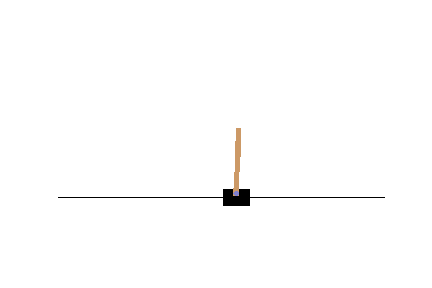
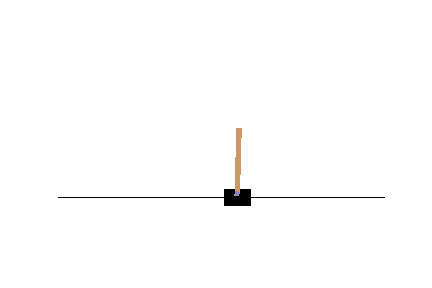
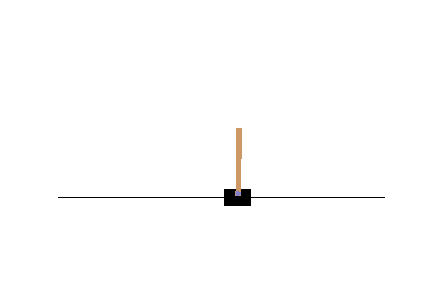
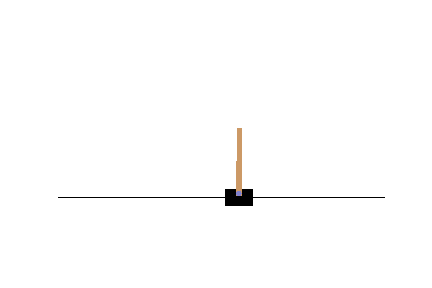
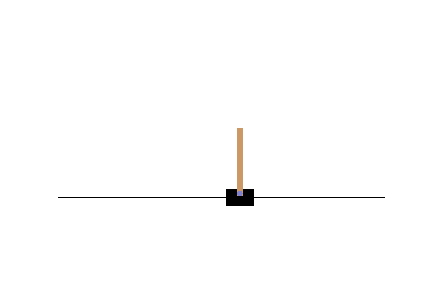
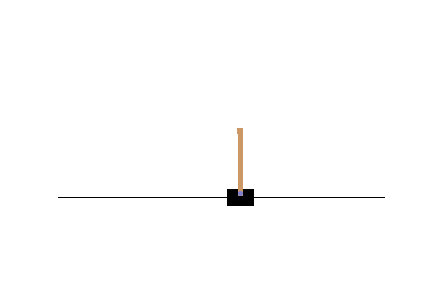
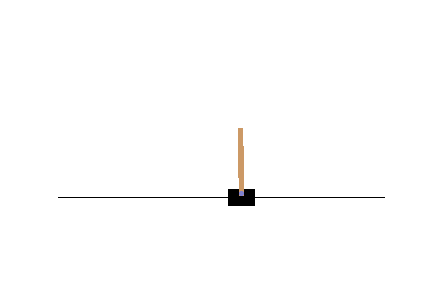
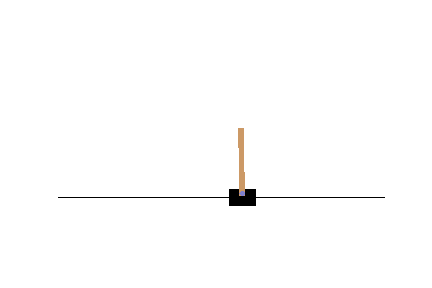
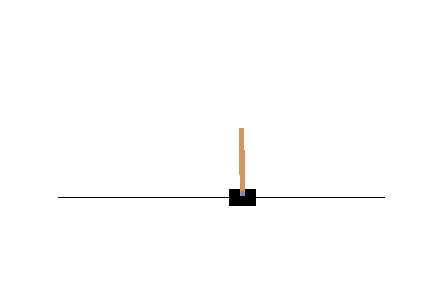
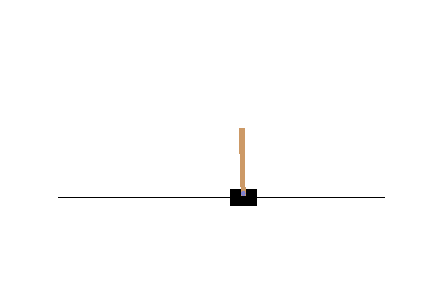
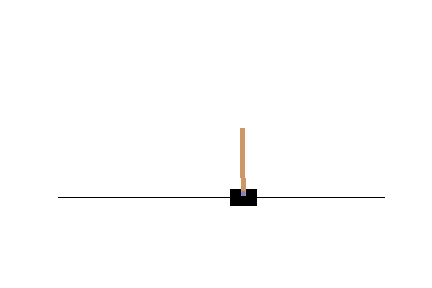
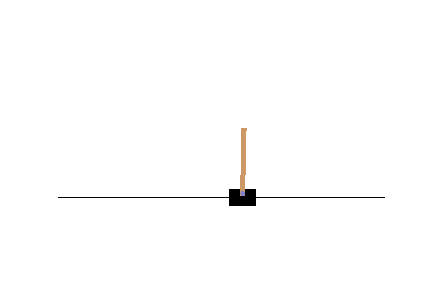
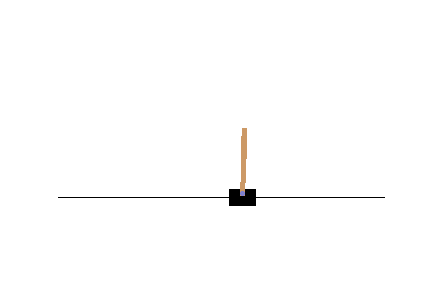
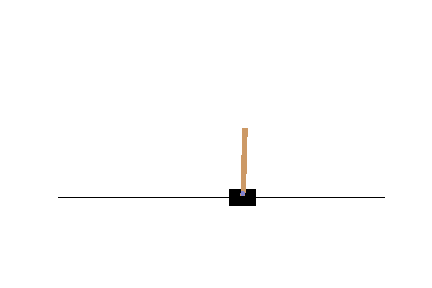
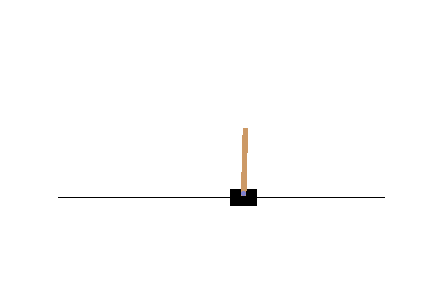
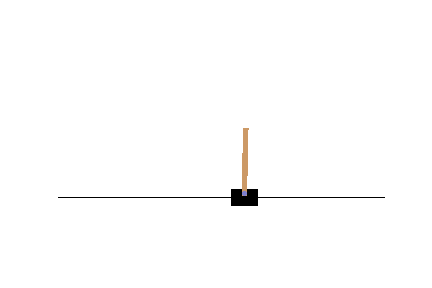
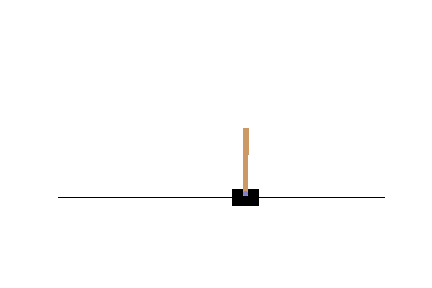
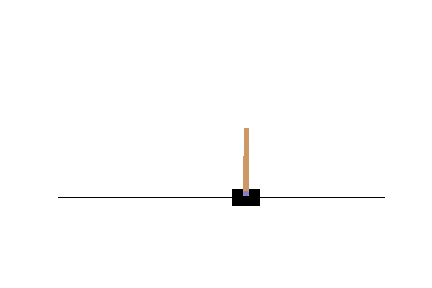
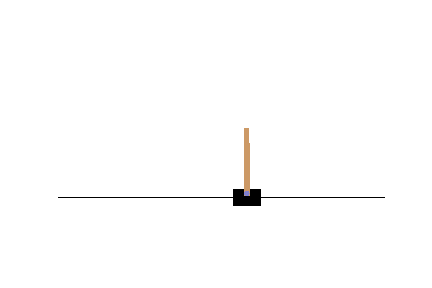
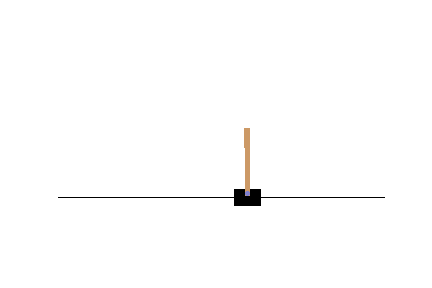
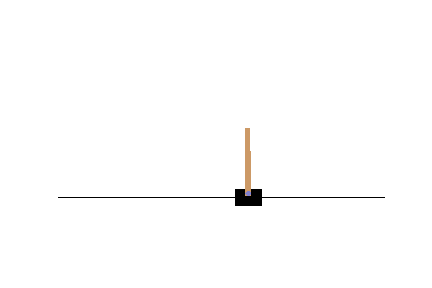
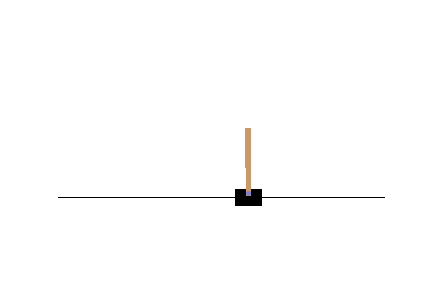
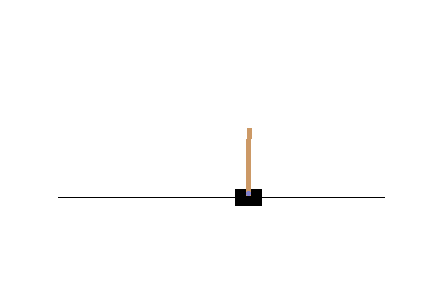
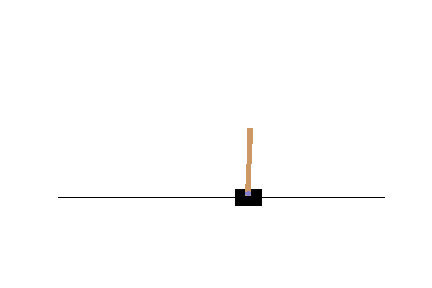
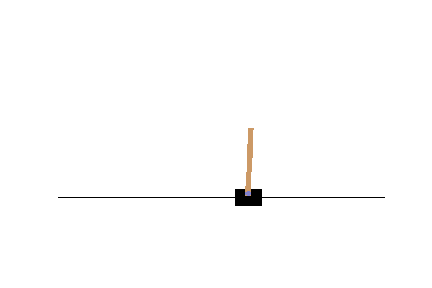
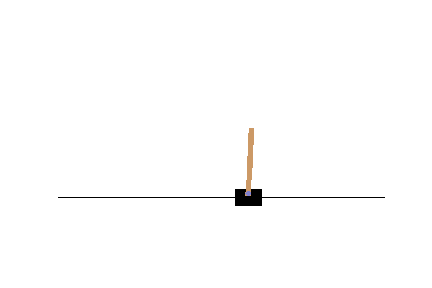
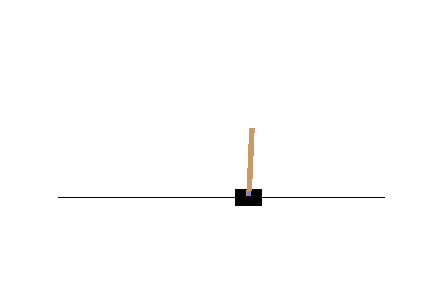
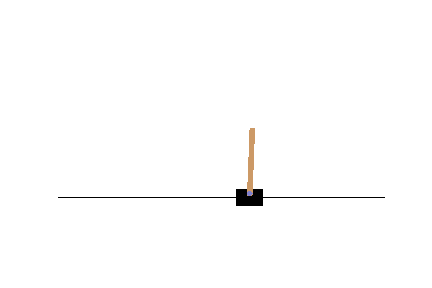
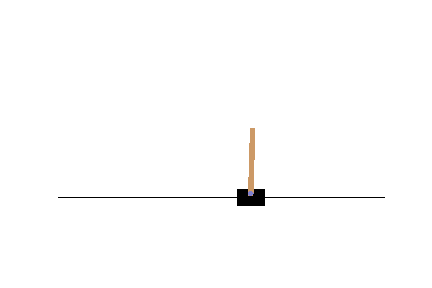
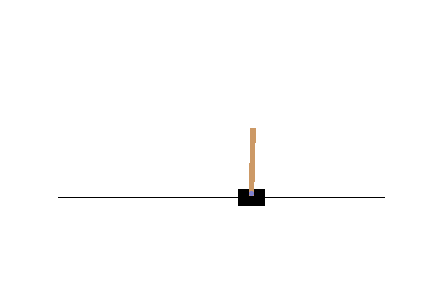
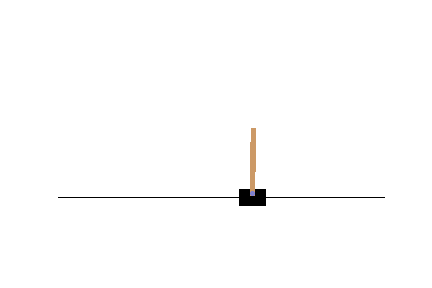
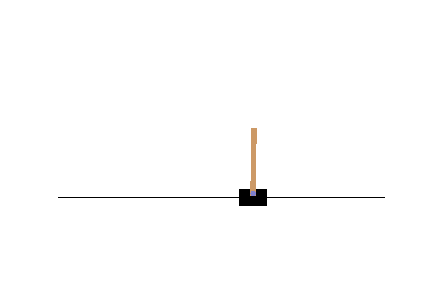
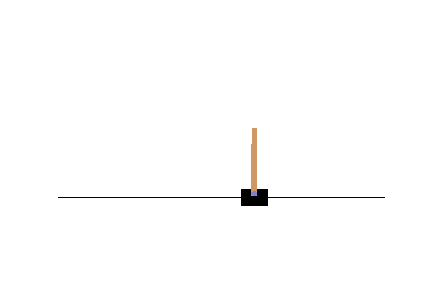
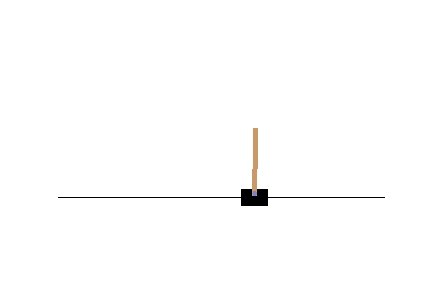
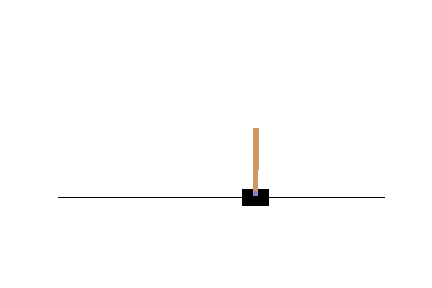
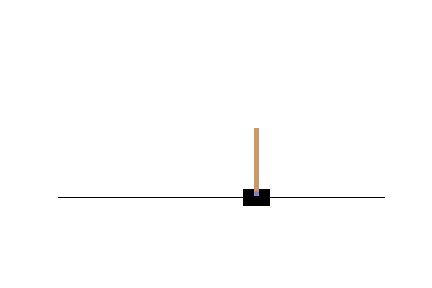
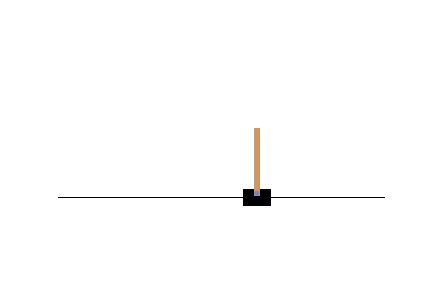
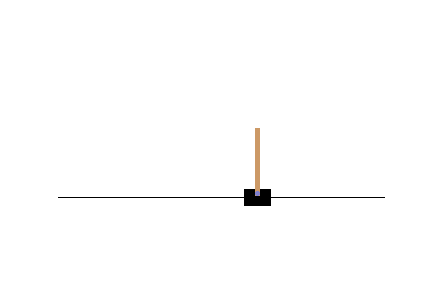
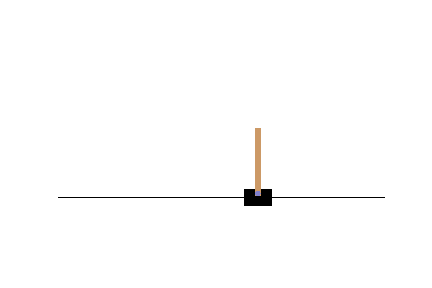
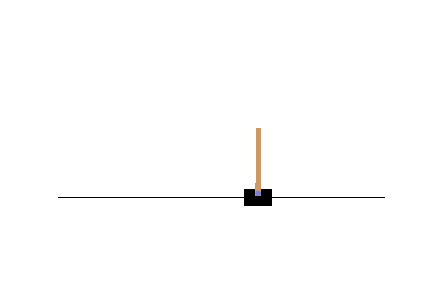
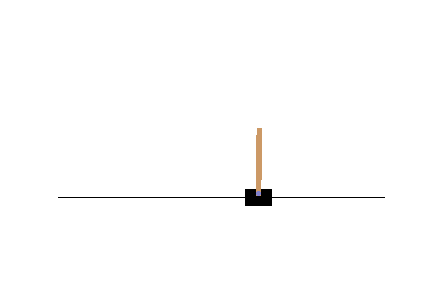
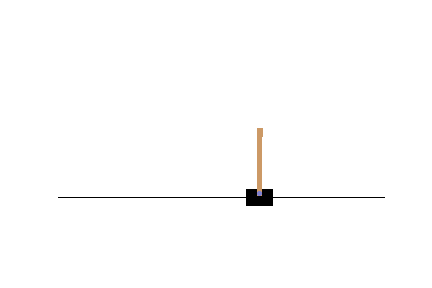
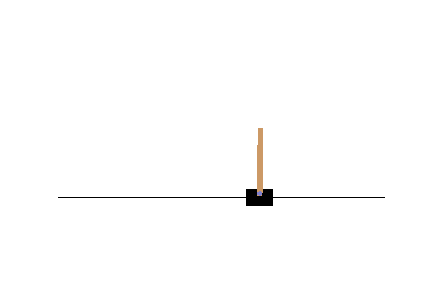
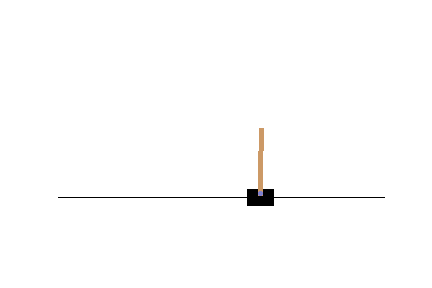
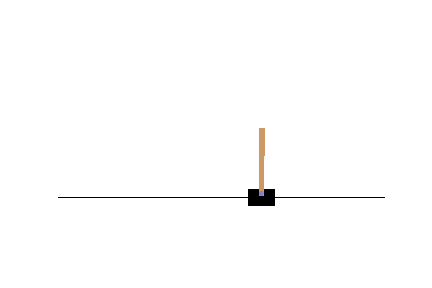
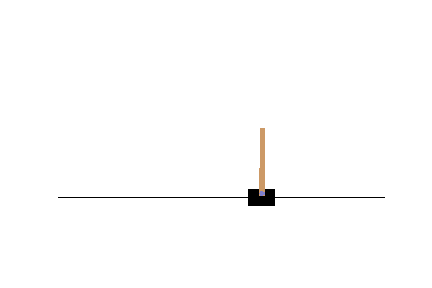
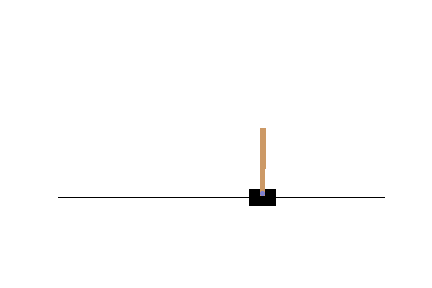
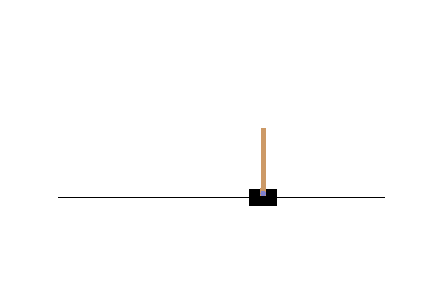
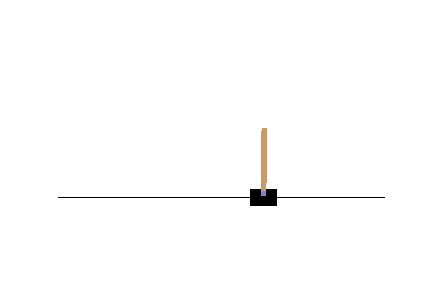
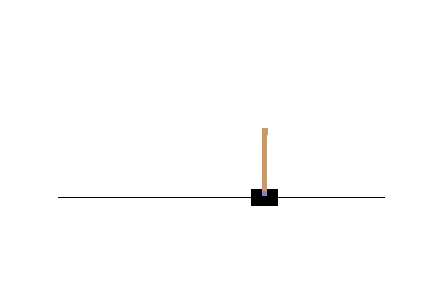
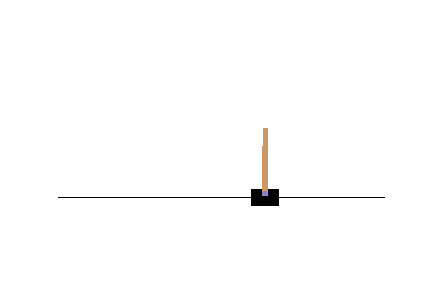
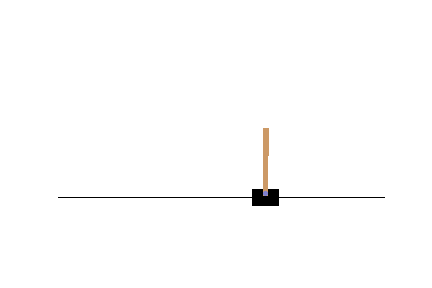
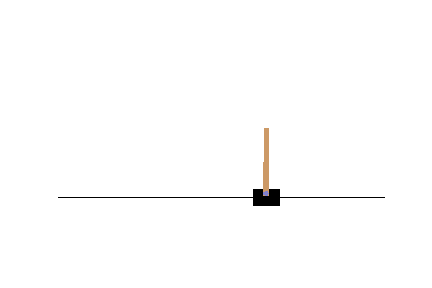
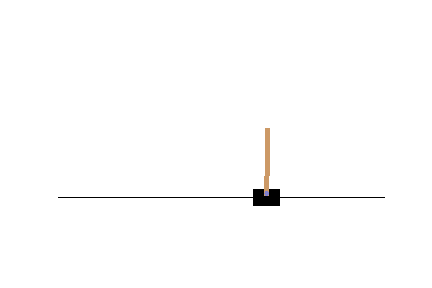
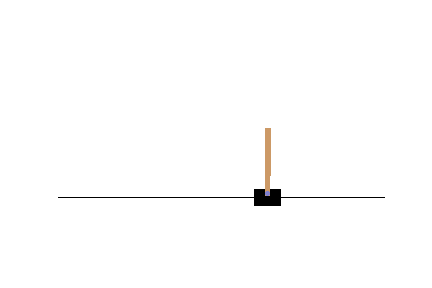
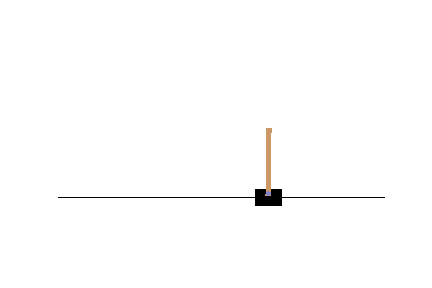
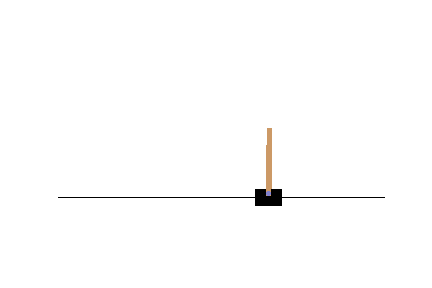
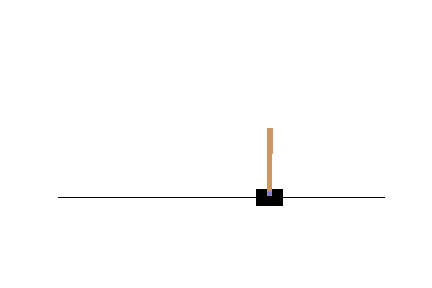
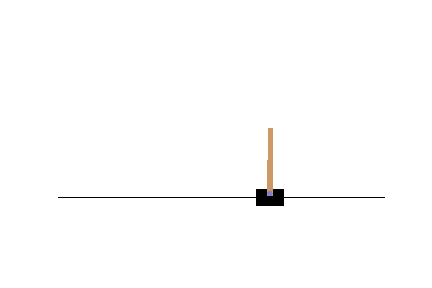
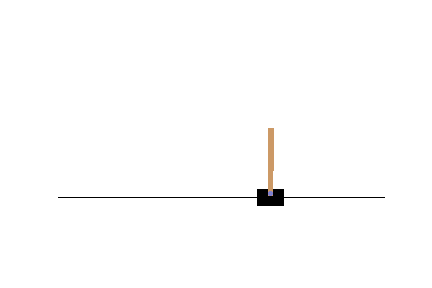
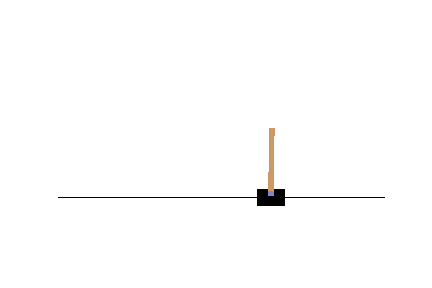
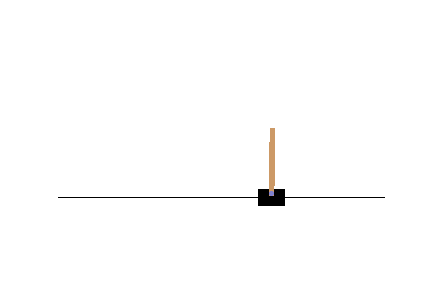
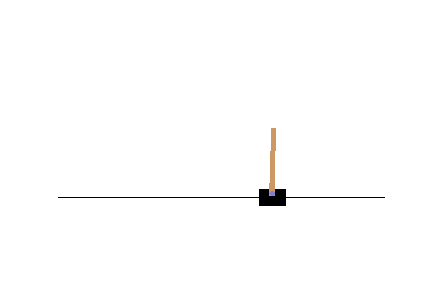
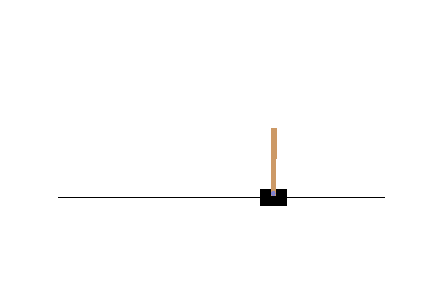
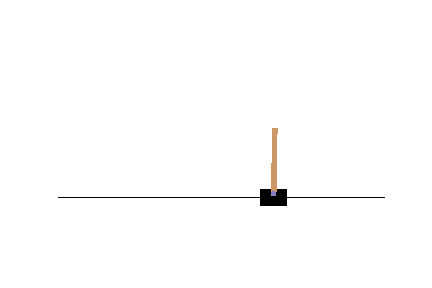
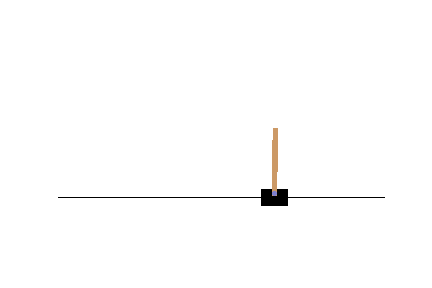
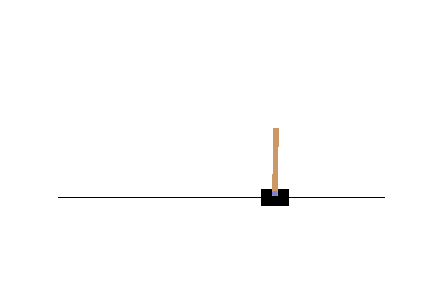
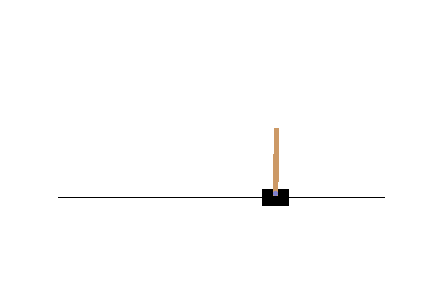
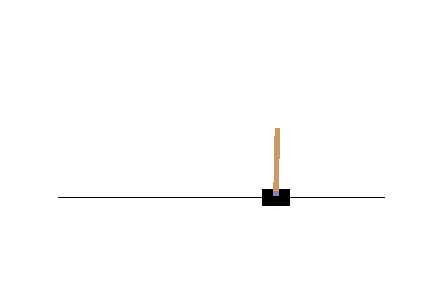
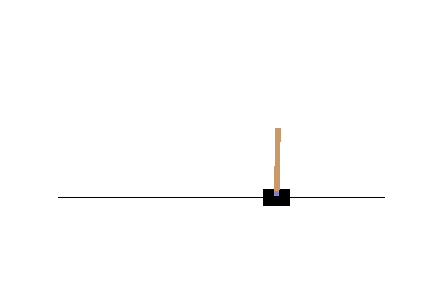
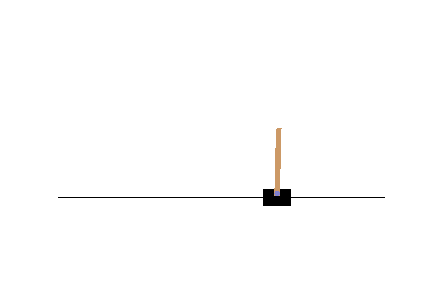
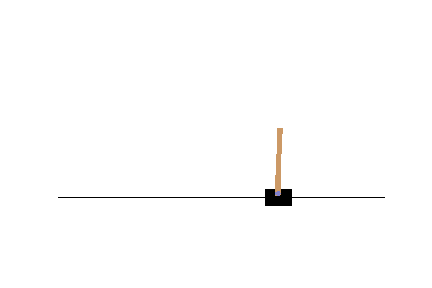
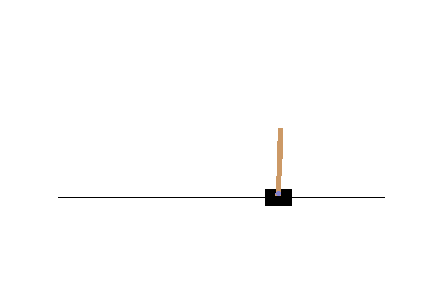
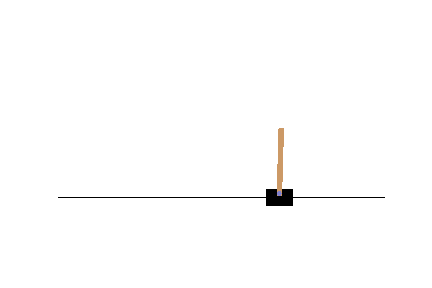
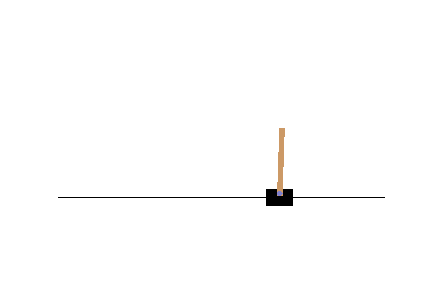
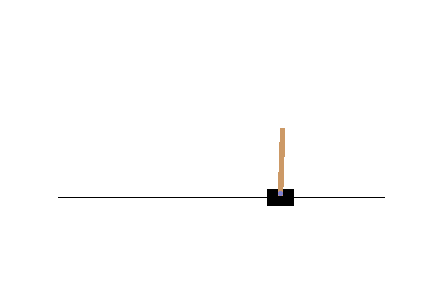
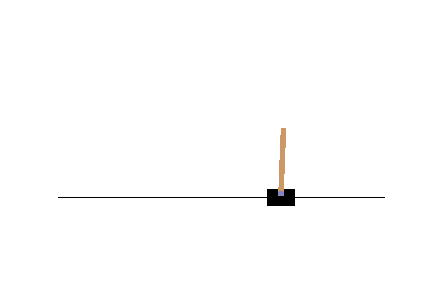
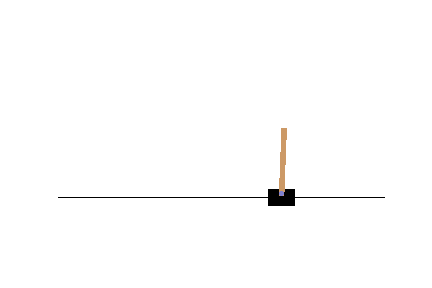
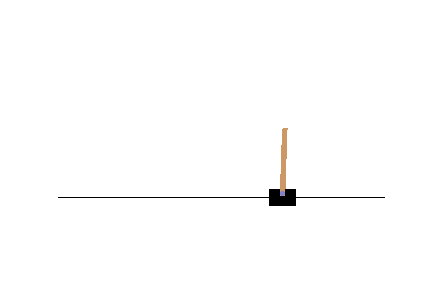
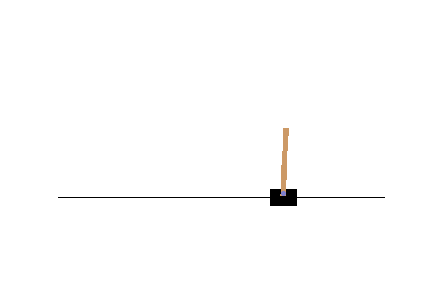
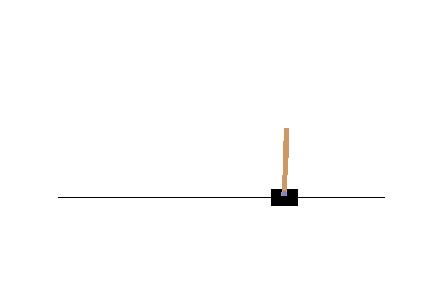
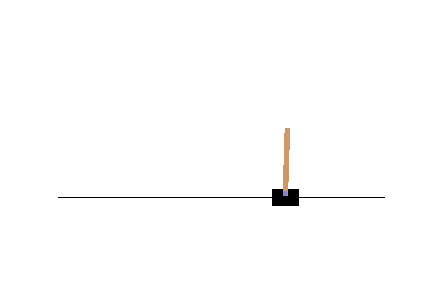

In [8]:
observation = env.reset()

frames = []
for _ in range(num_max_step):
    state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
    action = learning.get_action(state, episode)
    observation, reward, done, info =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

## 学習曲線

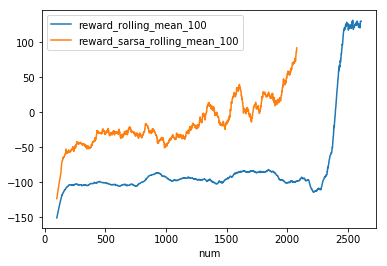

In [13]:
 # エピソード毎の獲得報酬を移動平均線で表示
df_rewards = pd.DataFrame({'num': range(0, len(rewards)), 'reward': rewards,})
df_rewards_sarsa = pd.DataFrame({'num': range(0, len(rewards_sarsa)), 'reward_sarsa': rewards_sarsa})

df_rewards['reward_rolling_mean_100'] = df_rewards['reward'].rolling(window=100,center=False).mean()
df_rewards_sarsa['reward_sarsa_rolling_mean_100'] = df_rewards_sarsa['reward_sarsa'].rolling(window=100,center=False).mean()

ax = df_rewards.plot(kind='line', x='num', y='reward_rolling_mean_100')
df_rewards_sarsa.plot(kind='line', x='num', y='reward_sarsa_rolling_mean_100', ax=ax)